In [1]:
import pandas
import os
import string
import itertools
import pickle
from biotite.sequence.phylo import neighbor_joining
from matplotlib import pyplot
from io import StringIO
from Bio import Phylo
from ete3 import Tree

In [2]:
data_path = "../../data"

In [3]:
types_map = dict(P="with Protein", N="with Nucleotides")

In [4]:
df = pandas.read_csv(f"{data_path}/final_cluster.csv")

In [5]:
df.describe()

Right        Total
count  1050.000000  1050.000000
mean     12.260000    19.714286
std       9.151413    10.502816
min       0.000000    14.000000
25%       6.000000    14.000000
50%      13.500000    14.000000
75%      14.000000    14.000000
max      39.000000    39.000000

In [6]:
df.sort_values(by="Right").head()

Type                                          Algorithm  \
638    P                            Universal Quality Index   
484    P  Unrestricted Sliced Structural Similarity Inde...   
483    P  Unrestricted Sliced Structural Similarity Inde...   
481    P  Unrestricted Sliced Structural Similarity Inde...   
480    P  Unrestricted Sliced Structural Similarity Inde...   

                                        Name                Family  Right  \
638  carlito_syrichta_ENSTSYG00000029754.png  orthologs_cytoglobin      0   
484                                   A9.png             indelible      0   
483                                   B6.png             indelible      0   
481                                   D5.png             indelible      0   
480                                   C7.png             indelible      0   

     Total  
638     14  
484     39  
483     39  
481     39  
480     39

In [7]:
df.groupby(["Type", "Algorithm"]).apply(lambda x: x[x["Right"] == x["Total"]].Name.size / x.Name.size)

Type  Algorithm                                              
N     Greedy Sliced Structural Similarity Index Measure          0.566667
      Resized MultiScale Structural Similarity Index Measure     0.500000
      Resized Structural Similarity Index Measure                0.500000
      Universal Quality Index                                    0.400000
      Unrestricted Sliced Structural Similarity Index Measure    0.750000
      Windowed MultiScale Structural Similarity Index Measure    0.766667
P     Greedy Sliced Structural Similarity Index Measure          0.260870
      Resized MultiScale Structural Similarity Index Measure     0.495652
      Resized Structural Similarity Index Measure                0.260870
      Universal Quality Index                                    0.739130
      Unrestricted Sliced Structural Similarity Index Measure    0.426087
      Windowed MultiScale Structural Similarity Index Measure    0.426087
dtype: float64

In [8]:
def color_clade(clade):
    green_pallete = [
        "darkolivegreen",
        "turquoise",
        "forestgreen",
        "green",
        "darkcyan",
        "teal",
        "mediumaquamarine",
        "seagreen",
        "limegreen",
        "mediumseagreen",
        "mediumspringgreen"]
    clade_colors = {
        "androglobin": "red",
        "cytoglobin": "orange",
        "neuroglobin": "blue",
        "myoglobin": "brown",
        "hemoglobin": "purple",
        "indelible": green_pallete
    }
    for name, color in clade_colors.items():
            if name in clade:
                return color if type(color) == str else color[int(clade[-1])]



In [9]:
def show_tree(types, alg, numpy_all):
    tree = neighbor_joining(abs(1.0-numpy_all))
    fig, ax = pyplot.subplots(1, 1, figsize=(10, 20), layout="constrained")
    newick = tree.to_newick(labels=list(fixed_df_all.columns), include_distance=False)
    newick = tree.to_newick(labels=["_".join(i.replace("-", "_").split("_")[1:]) for i in list(fixed_df_all.columns)], include_distance=False)
    with open(f"{data_path}/blast/{types}/db_blast {alg}.nw", "w") as f:
        f.write(newick)
    t = Phylo.read(StringIO(newick), "newick")
    #     t.ladderize()
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{alg} {types_map[types]}")
    ax.axis('off')
    Phylo.draw(
        t,
        show_confidence=False,
        axes=ax,
        do_show=False,
        label_colors=color_clade,
        branch_labels=lambda clade: "" if not clade.name else "{:.2f}".format(
            clade.confidence) if clade.confidence else ""
    )
    pyplot.xlabel("")
    pyplot.ylabel("")
    pyplot.tight_layout()
    pyplot.show()

In [10]:
def calc_map(types, alg, fixed_df_all):
    by_homologues = {}
    only_homologues = {}
    for column in fixed_df_all.columns:
        name = column.split("_")[0] if len(column.split("_")) == 2 else column.split("_")[1]
        k = 40 if len(column.split("_")) == 2 else 14
        if name in by_homologues:
            by_homologues[name] += list(fixed_df_all[column].sort_values(ascending=False).index[:k])
            only_homologues[name] += [i.split("_")[0] if len(i.split("_")) == 2 else i.split("_")[1] for i in fixed_df_all[column].sort_values(ascending=False).index[:k]]
        else:
            by_homologues[name] = list(fixed_df_all[column].sort_values(ascending=False).index[:k])
            only_homologues[name] = [i.split("_")[0] if len(i.split("_")) == 2 else i.split("_")[1] for i in fixed_df_all[column].sort_values(ascending=False).index[:k]]

    #Precision, MAP
    print(f"--------{alg} {types_map[types]}--------")
    for h in only_homologues:
        print(h)
        print("Precision:", sum([i==h for i in only_homologues[h]])/len(only_homologues[h]))
        precision = [0]
        p_k = 0
        for i in only_homologues[h]:
            precision.append((i==h)+precision[-1])
        for k in range(1,len(precision)):
            p_k += precision[k]/k
        print("Mean Average Precision", p_k/len(only_homologues[h]))
        print("-------------------------------------------------")

--------Resized Structural Similarity Index Measure with Protein--------
indelible
Precision: 0.054375
Mean Average Precision 0.06260358813551994
-------------------------------------------------
androglobin
Precision: 0.06666666666666667
Mean Average Precision 0.045779142126483444
-------------------------------------------------
cytoglobin
Precision: 0.1619047619047619
Mean Average Precision 0.17746143160714628
-------------------------------------------------
hemoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
myoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
neuroglobin
Precision: 0.7428571428571429
Mean Average Precision 0.6922355751409691
-------------------------------------------------


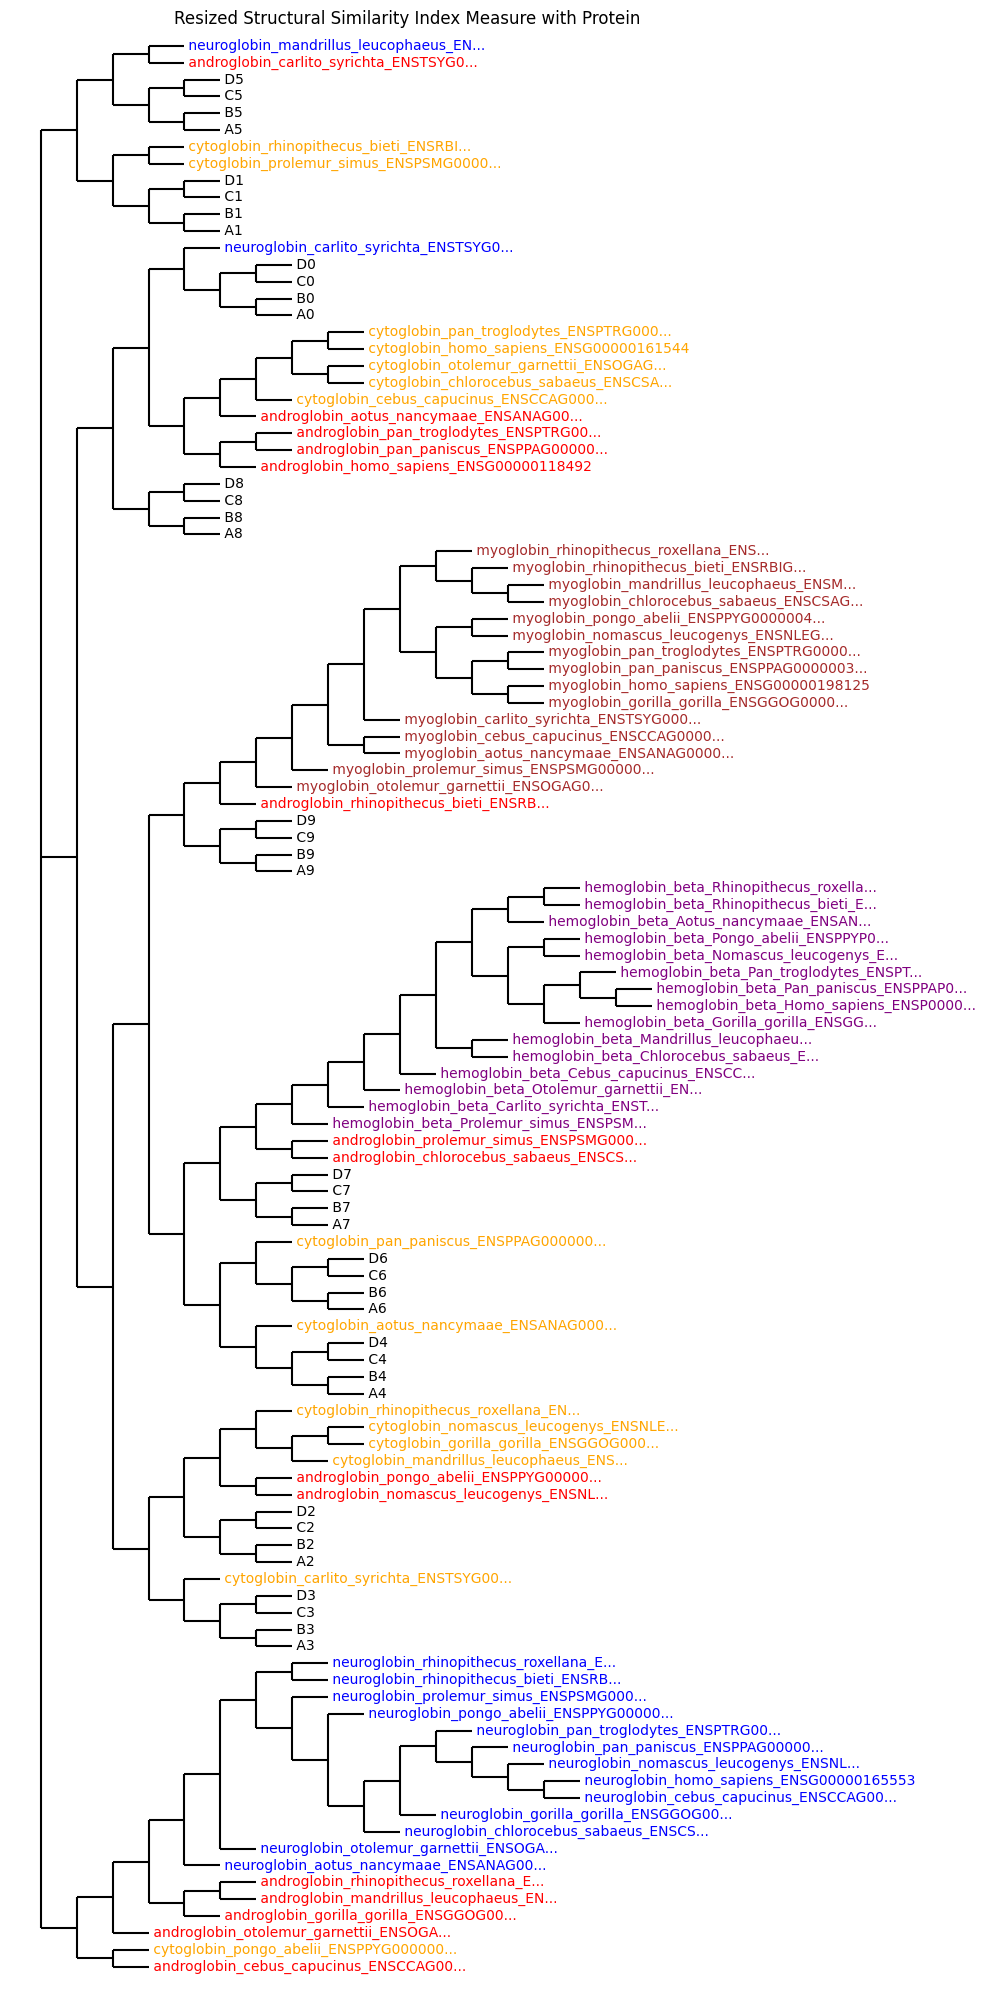

--------Resized MultiScale Structural Similarity Index Measure with Protein--------
indelible
Precision: 0.973125
Mean Average Precision 0.9753887851417457
-------------------------------------------------
androglobin
Precision: 0.8666666666666667
Mean Average Precision 0.9030845131822275
-------------------------------------------------
cytoglobin
Precision: 0.6333333333333333
Mean Average Precision 0.5862426435436952
-------------------------------------------------
hemoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
myoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
neuroglobin
Precision: 0.8047619047619048
Mean Average Precision 0.8374720970111587
-------------------------------------------------


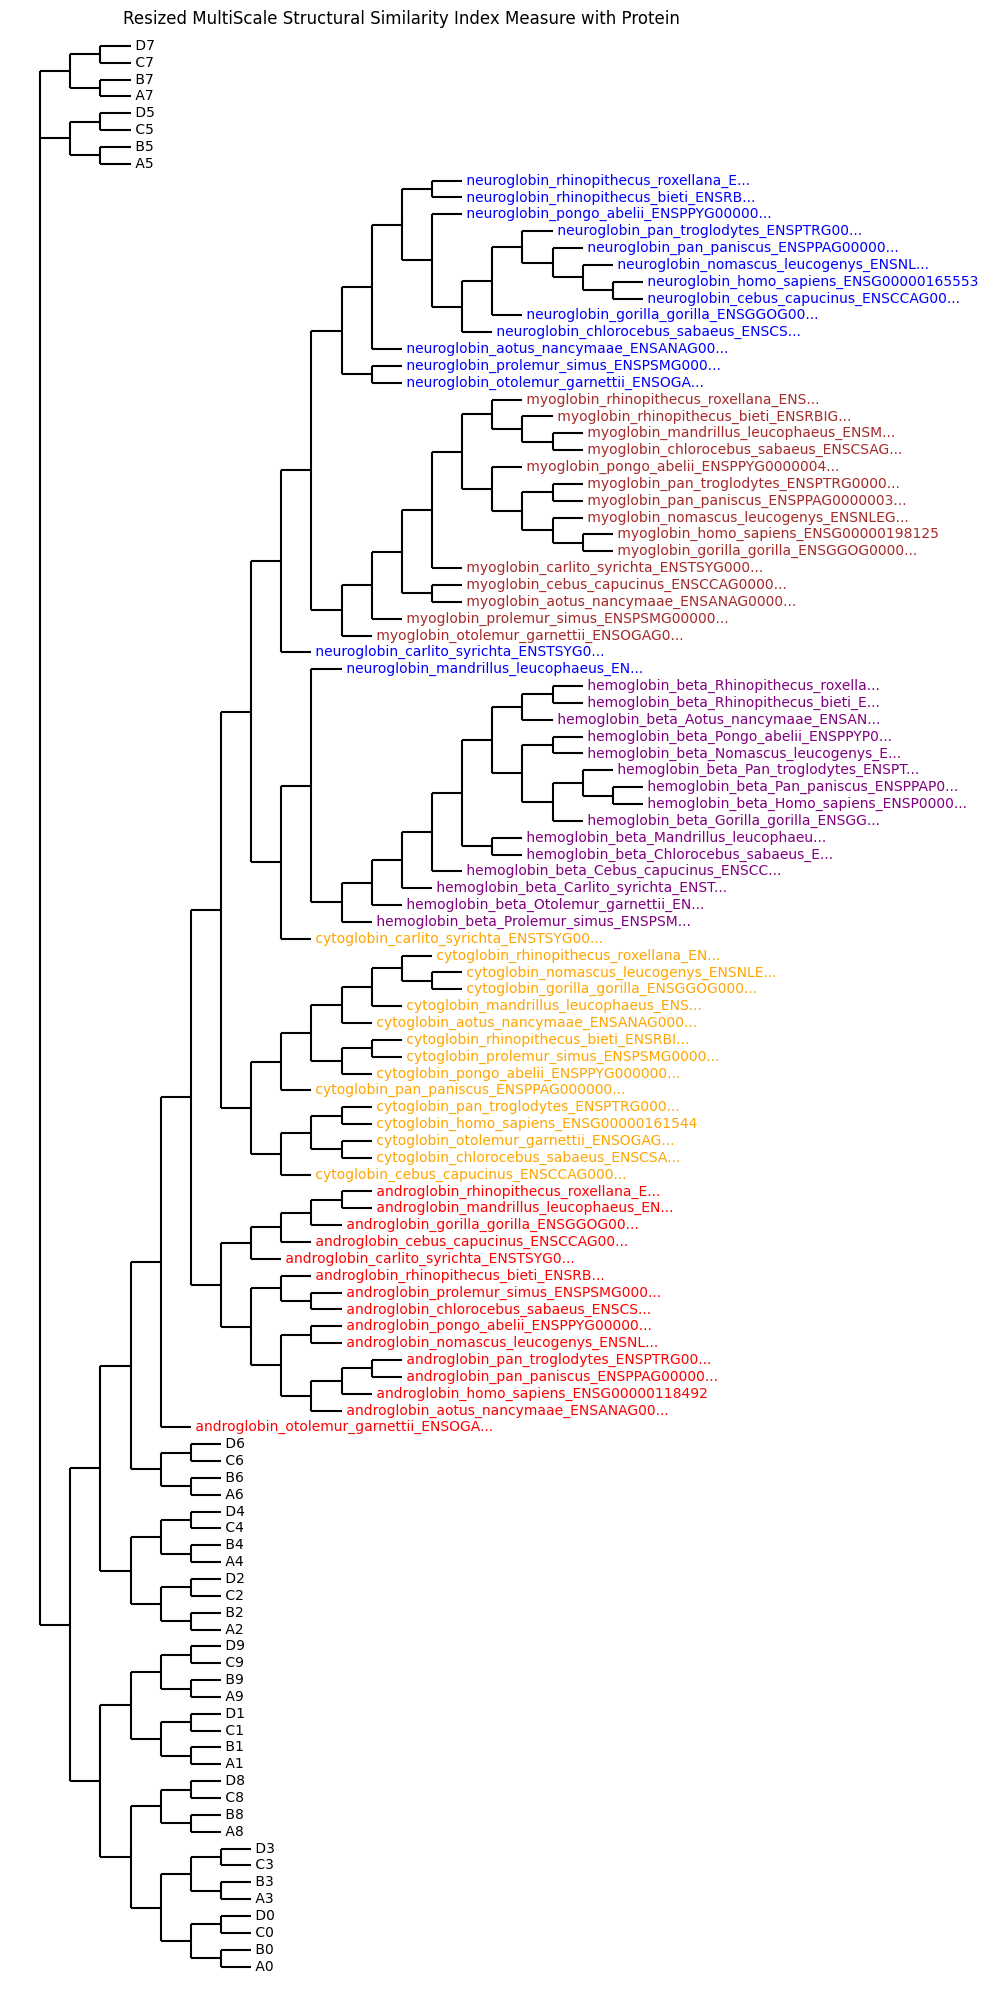

--------Windowed MultiScale Structural Similarity Index Measure with Protein--------
indelible
Precision: 0.0175
Mean Average Precision 0.011496416285344022
-------------------------------------------------
androglobin
Precision: 0.8095238095238095
Mean Average Precision 0.7484843346273262
-------------------------------------------------
cytoglobin
Precision: 0.8857142857142857
Mean Average Precision 0.9255957224010676
-------------------------------------------------
hemoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
myoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
neuroglobin
Precision: 0.9904761904761905
Mean Average Precision 0.986643450773519
-------------------------------------------------


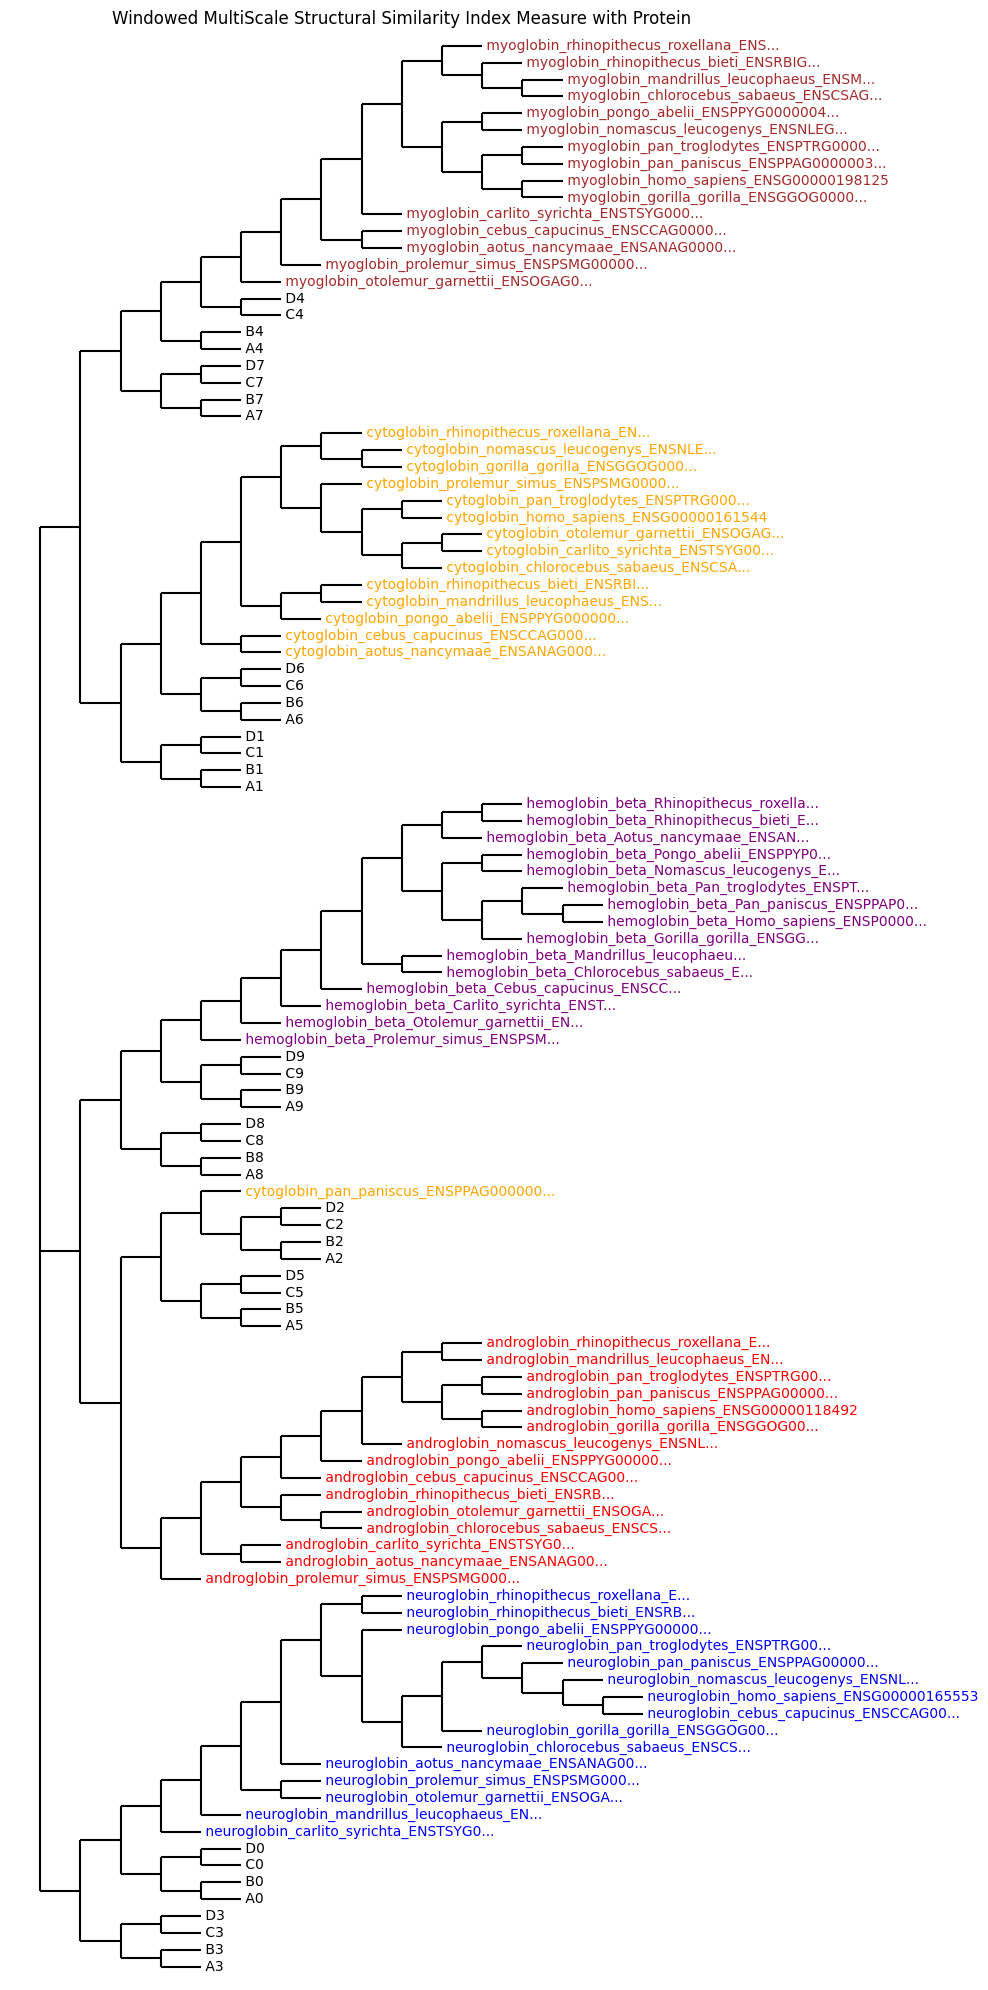

--------Greedy Sliced Structural Similarity Index Measure with Protein--------
indelible
Precision: 0.07375
Mean Average Precision 0.08275640835095524
-------------------------------------------------
androglobin
Precision: 0.45714285714285713
Mean Average Precision 0.32452211088537
-------------------------------------------------
cytoglobin
Precision: 0.7761904761904762
Mean Average Precision 0.7489829353286391
-------------------------------------------------
hemoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
myoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
neuroglobin
Precision: 0.7428571428571429
Mean Average Precision 0.6922355751409691
-------------------------------------------------


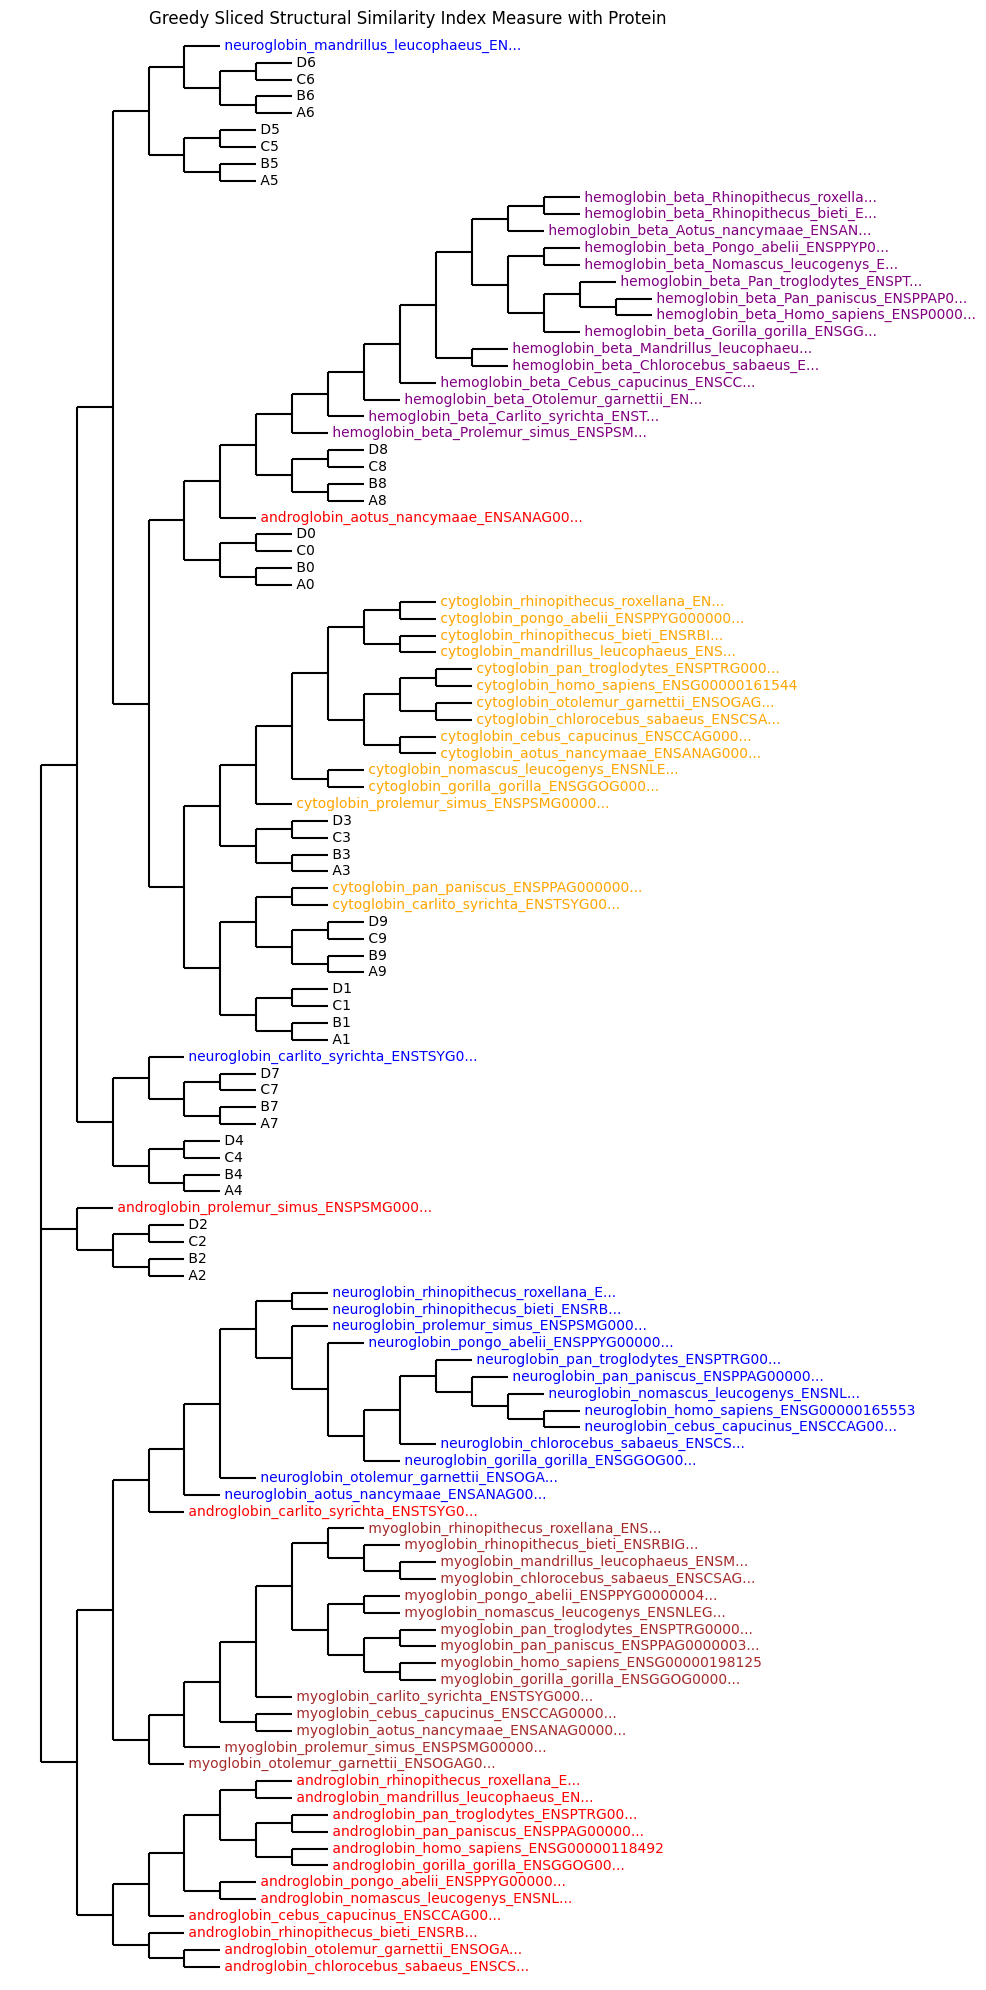

--------Unrestricted Sliced Structural Similarity Index Measure with Protein--------
indelible
Precision: 0.00125
Mean Average Precision 0.0004030428817283587
-------------------------------------------------
androglobin
Precision: 0.8047619047619048
Mean Average Precision 0.7480005754159166
-------------------------------------------------
cytoglobin
Precision: 0.8857142857142857
Mean Average Precision 0.9255957224010676
-------------------------------------------------
hemoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
myoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
neuroglobin
Precision: 0.9904761904761905
Mean Average Precision 0.986643450773519
-------------------------------------------------


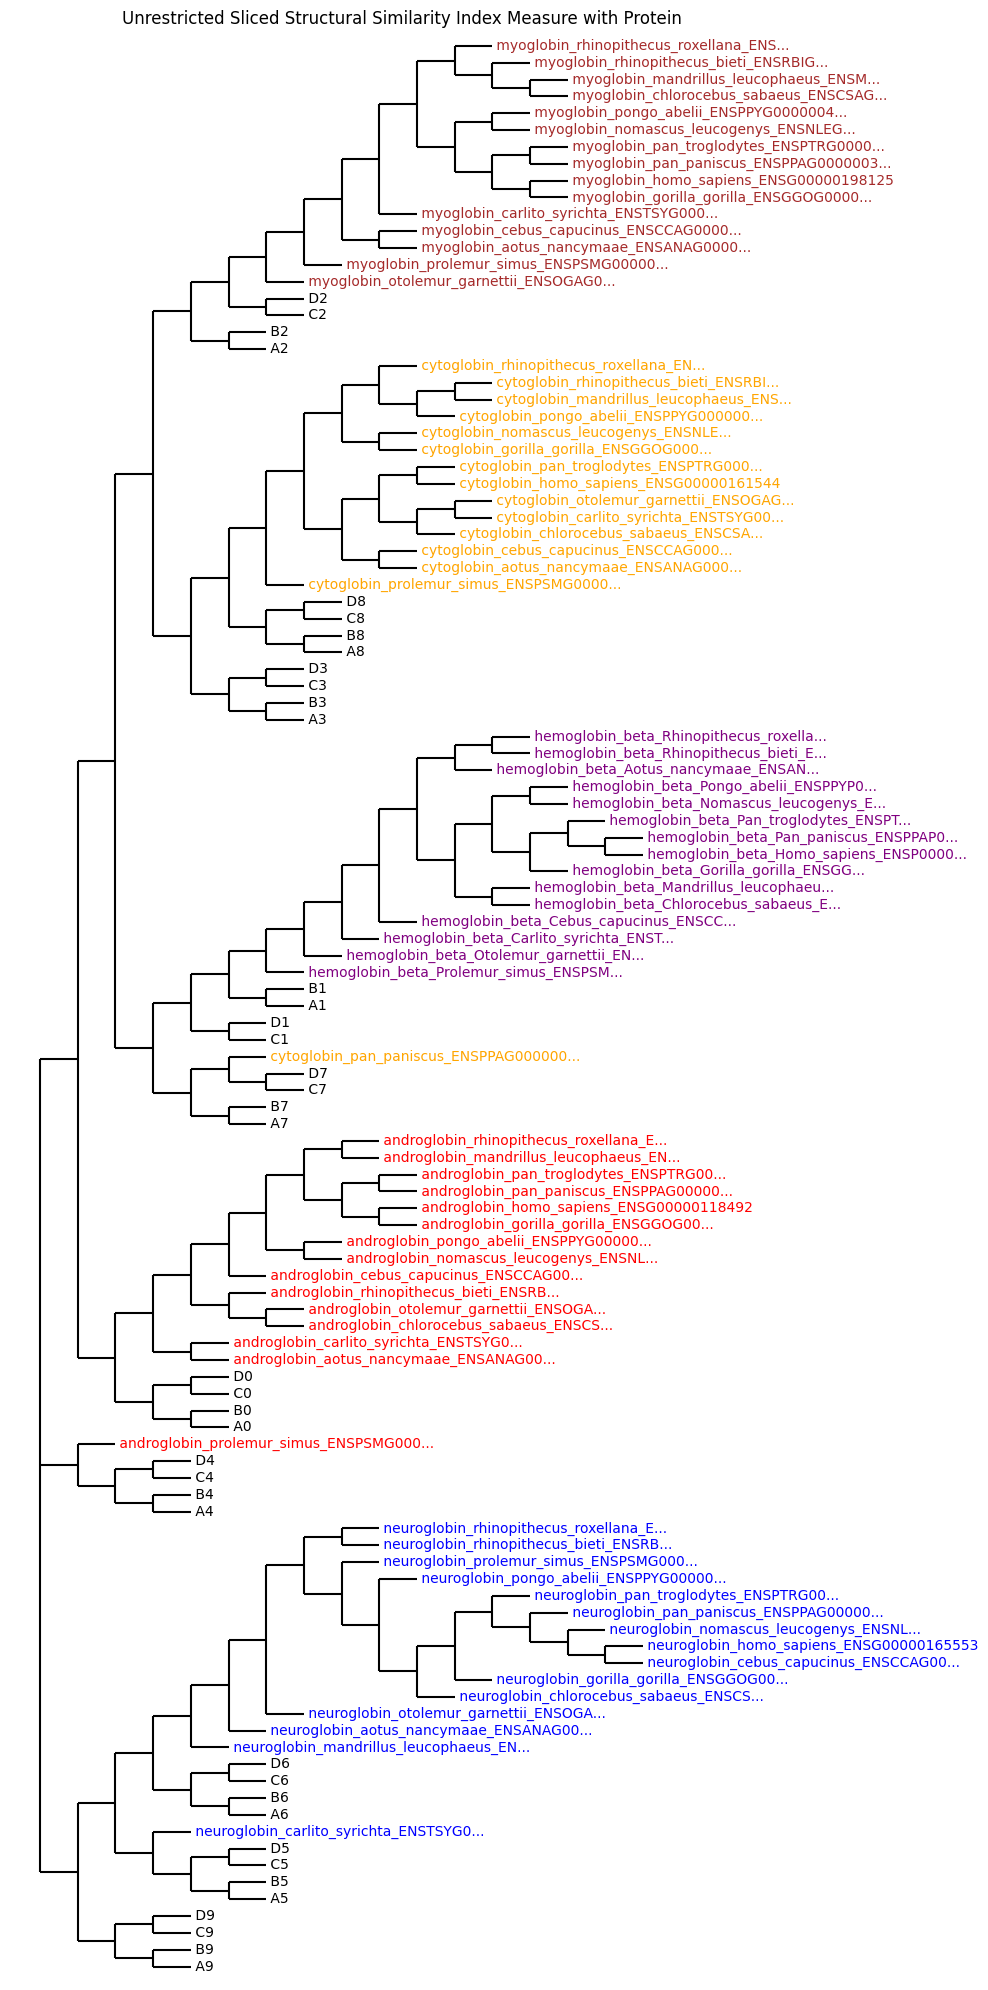

--------Universal Quality Index with Protein--------
indelible
Precision: 0.975
Mean Average Precision 0.9766871229250671
-------------------------------------------------
androglobin
Precision: 0.2904761904761905
Mean Average Precision 0.3137344325296148
-------------------------------------------------
cytoglobin
Precision: 0.7761904761904762
Mean Average Precision 0.7337938522541317
-------------------------------------------------
hemoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
myoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
neuroglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------


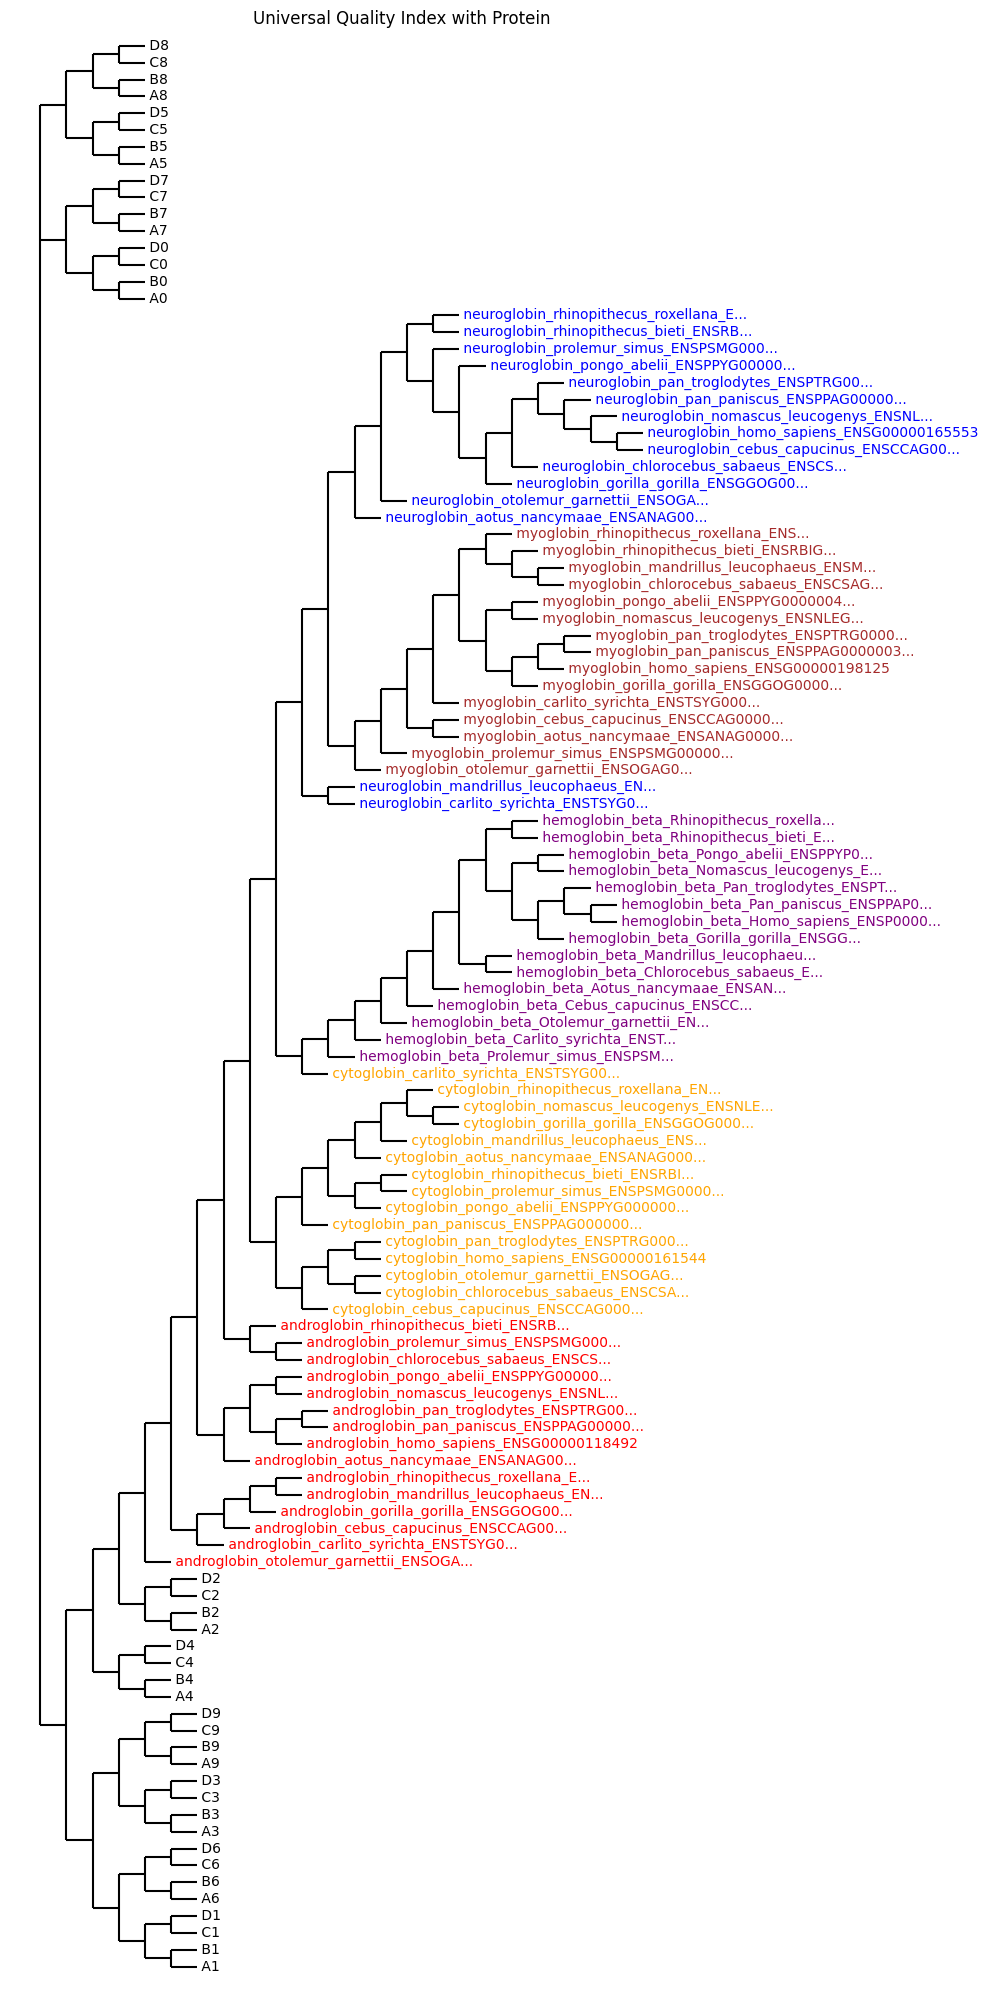

--------Resized Structural Similarity Index Measure with Nucleotides--------
cytoglobin
Precision: 0.3761904761904762
Mean Average Precision 0.44313484534507197
-------------------------------------------------
hemoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
myoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
neuroglobin
Precision: 0.7619047619047619
Mean Average Precision 0.7217625574900176
-------------------------------------------------


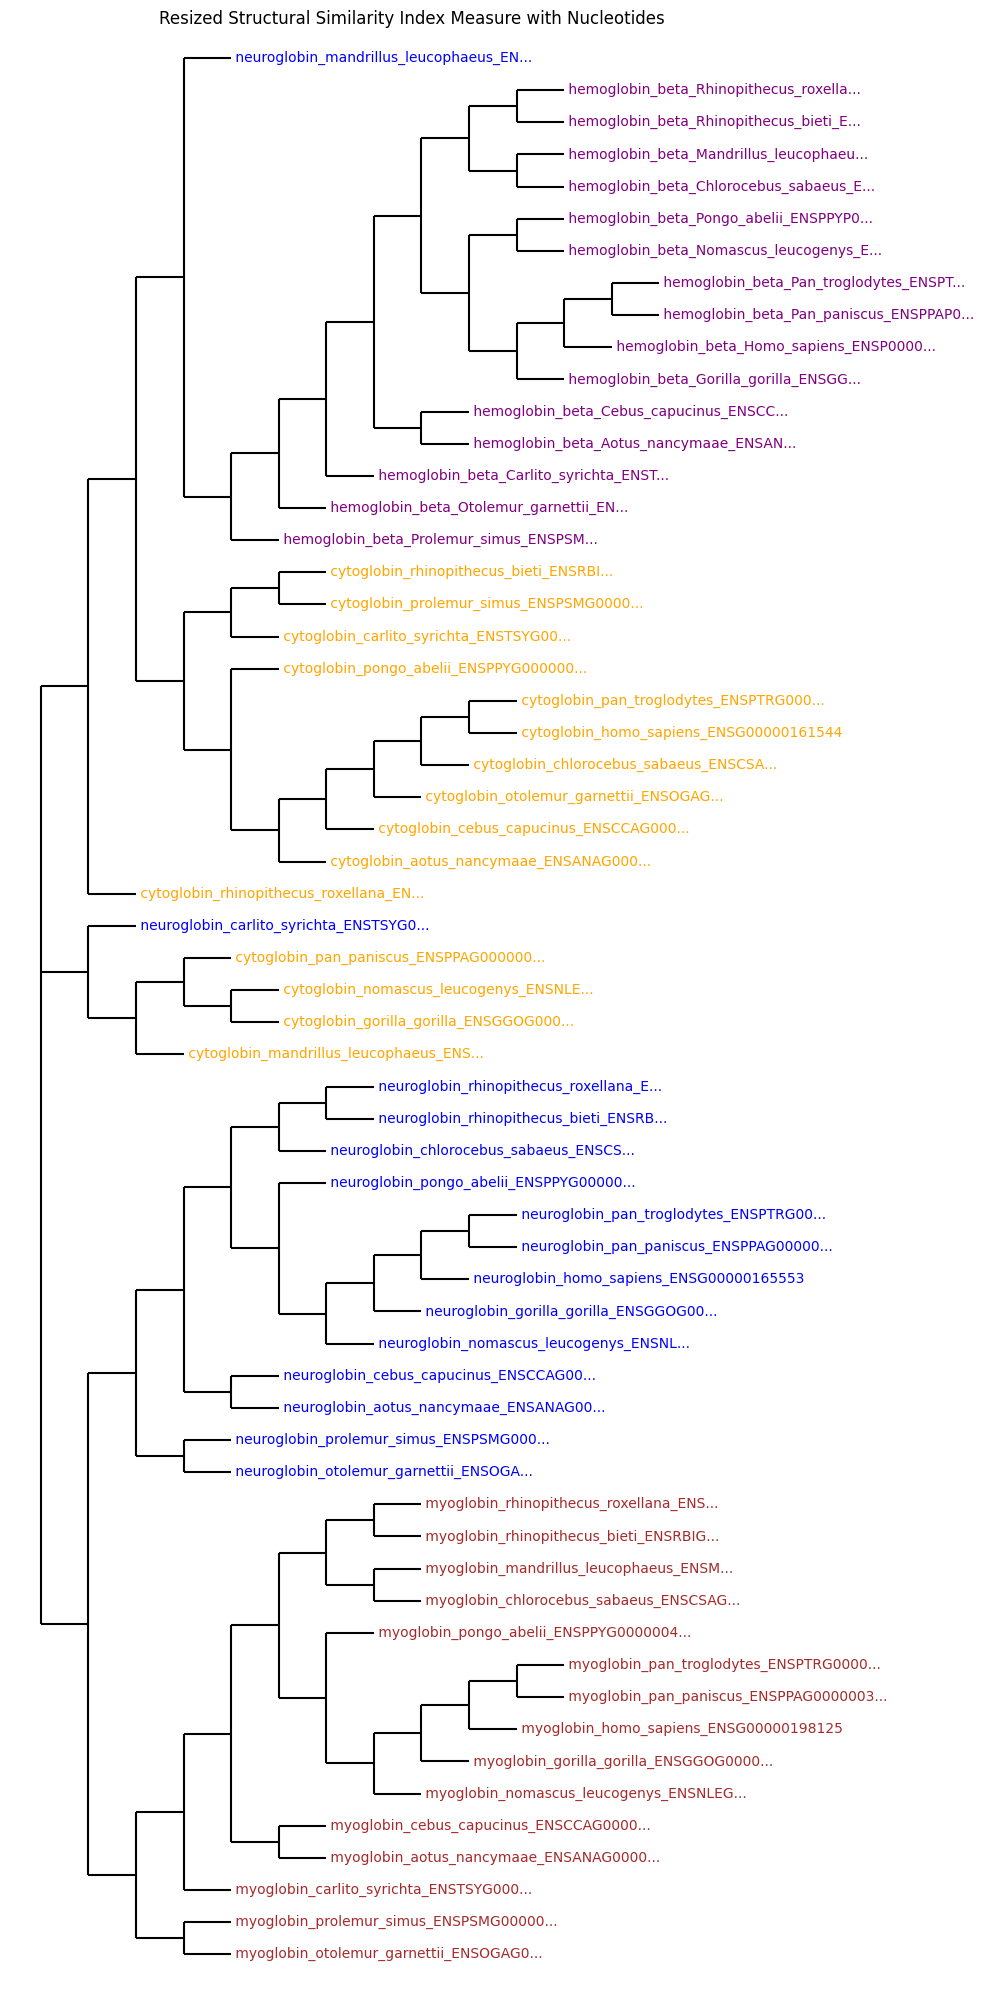

--------Resized MultiScale Structural Similarity Index Measure with Nucleotides--------
cytoglobin
Precision: 0.38095238095238093
Mean Average Precision 0.45005618596536273
-------------------------------------------------
hemoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
myoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
neuroglobin
Precision: 0.7857142857142857
Mean Average Precision 0.7891279168648845
-------------------------------------------------


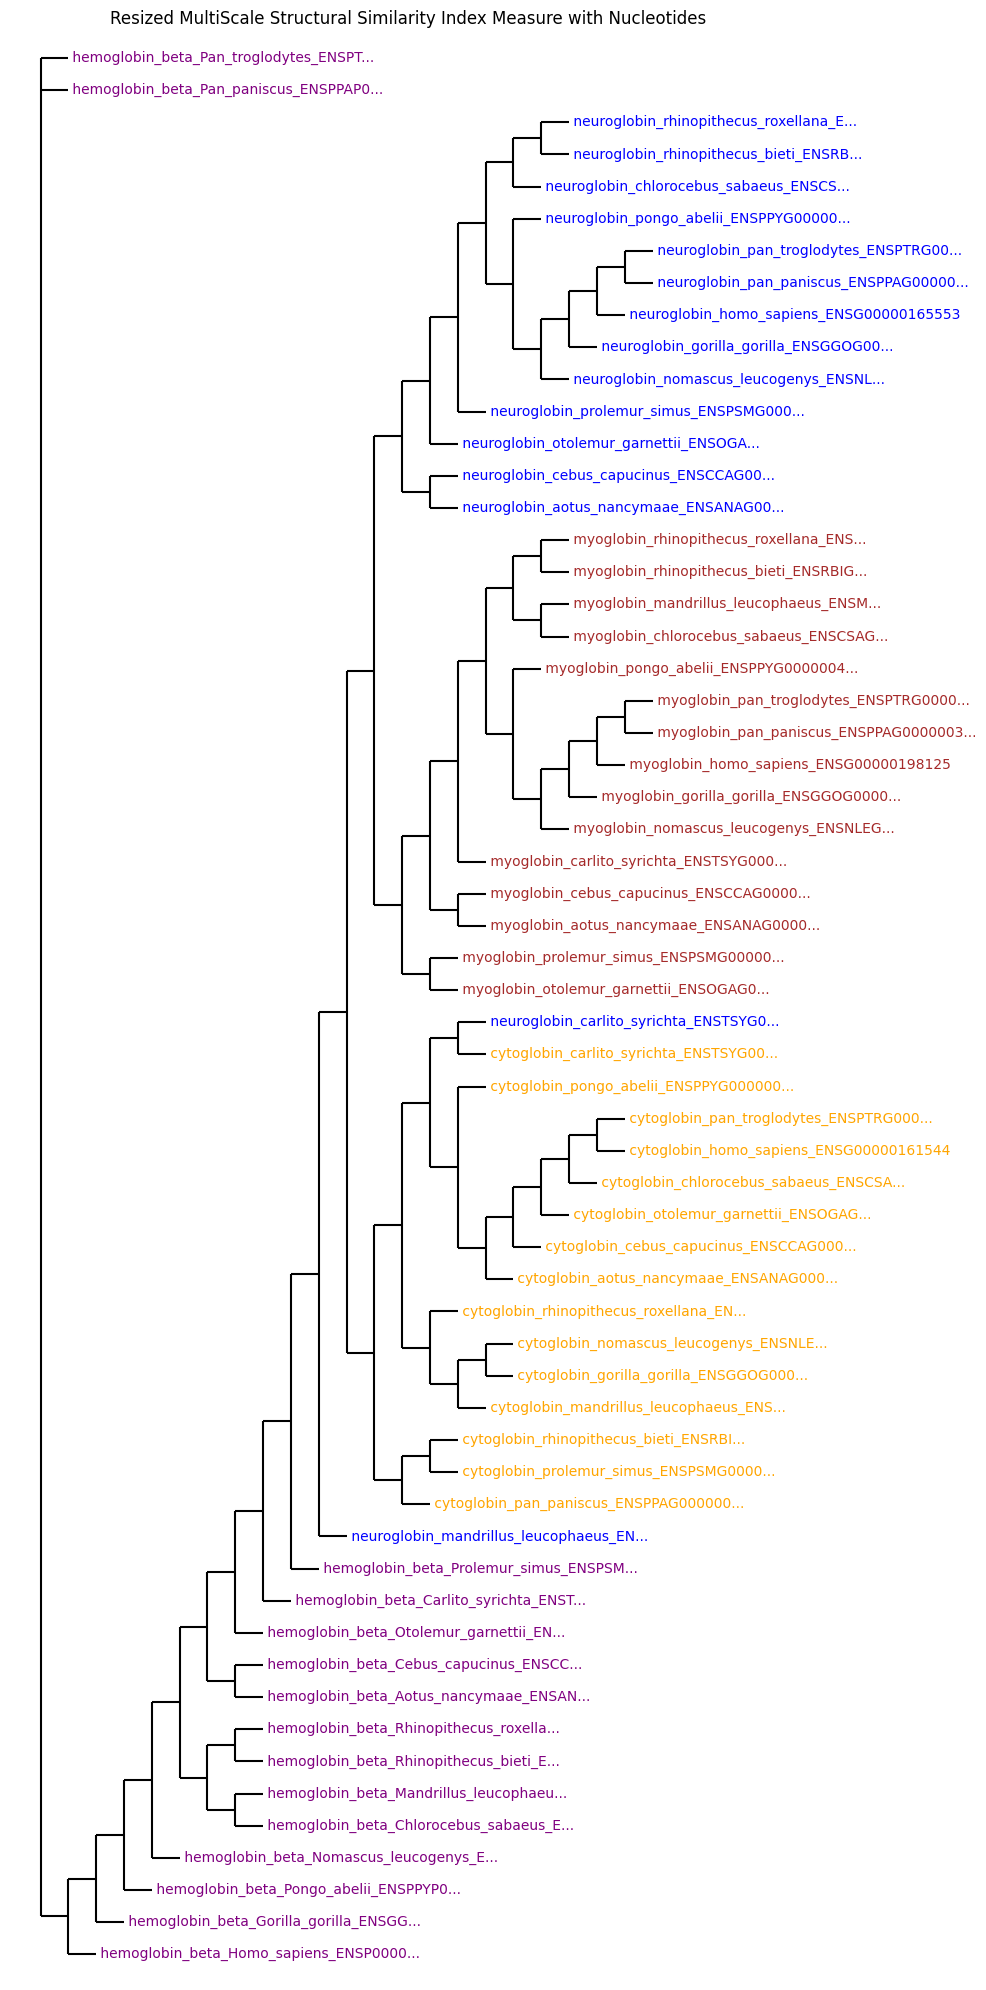

--------Windowed MultiScale Structural Similarity Index Measure with Nucleotides--------
cytoglobin
Precision: 0.8952380952380953
Mean Average Precision 0.931610889059277
-------------------------------------------------
hemoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
myoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
neuroglobin
Precision: 0.9904761904761905
Mean Average Precision 0.986643450773519
-------------------------------------------------


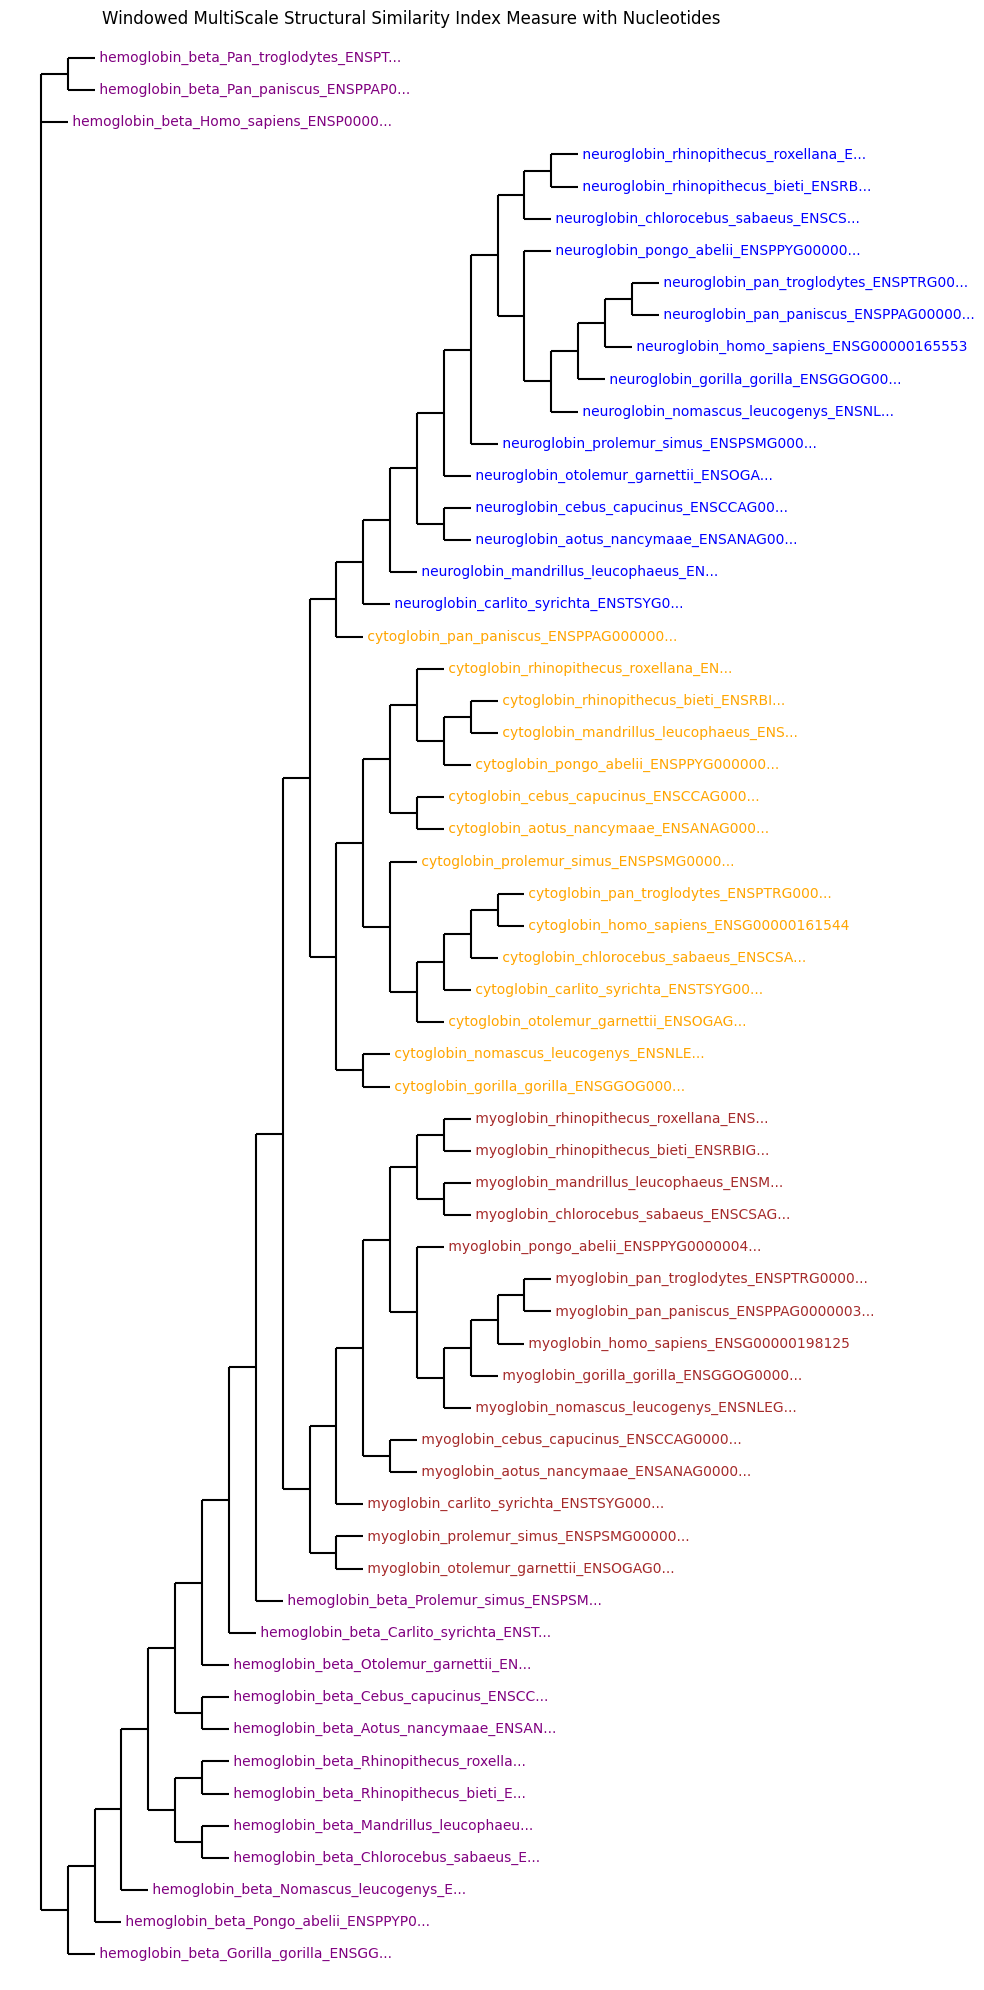

--------Greedy Sliced Structural Similarity Index Measure with Nucleotides--------
cytoglobin
Precision: 0.9142857142857143
Mean Average Precision 0.939149674250078
-------------------------------------------------
hemoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
myoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
neuroglobin
Precision: 0.7428571428571429
Mean Average Precision 0.6922355751409691
-------------------------------------------------


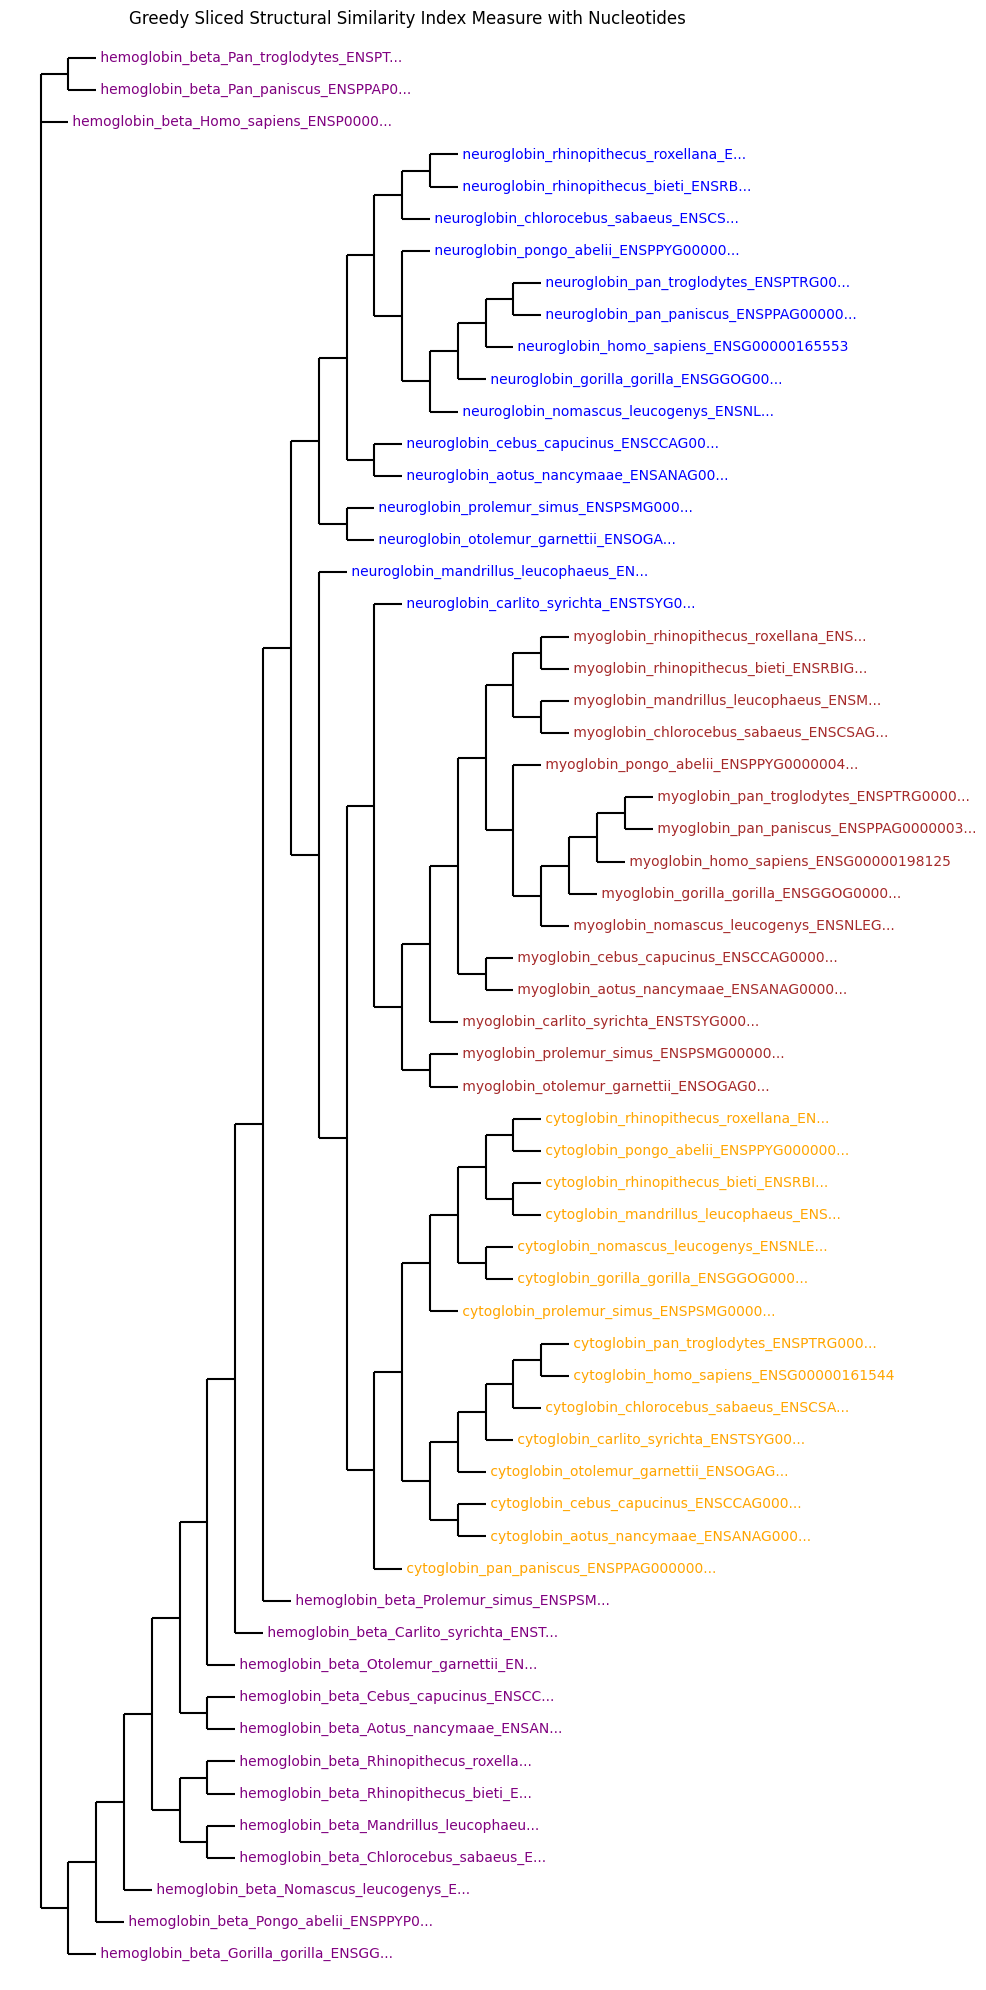

--------Unrestricted Sliced Structural Similarity Index Measure with Nucleotides--------
cytoglobin
Precision: 0.8952380952380953
Mean Average Precision 0.9301144745130173
-------------------------------------------------
hemoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
myoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
neuroglobin
Precision: 0.9904761904761905
Mean Average Precision 0.986643450773519
-------------------------------------------------


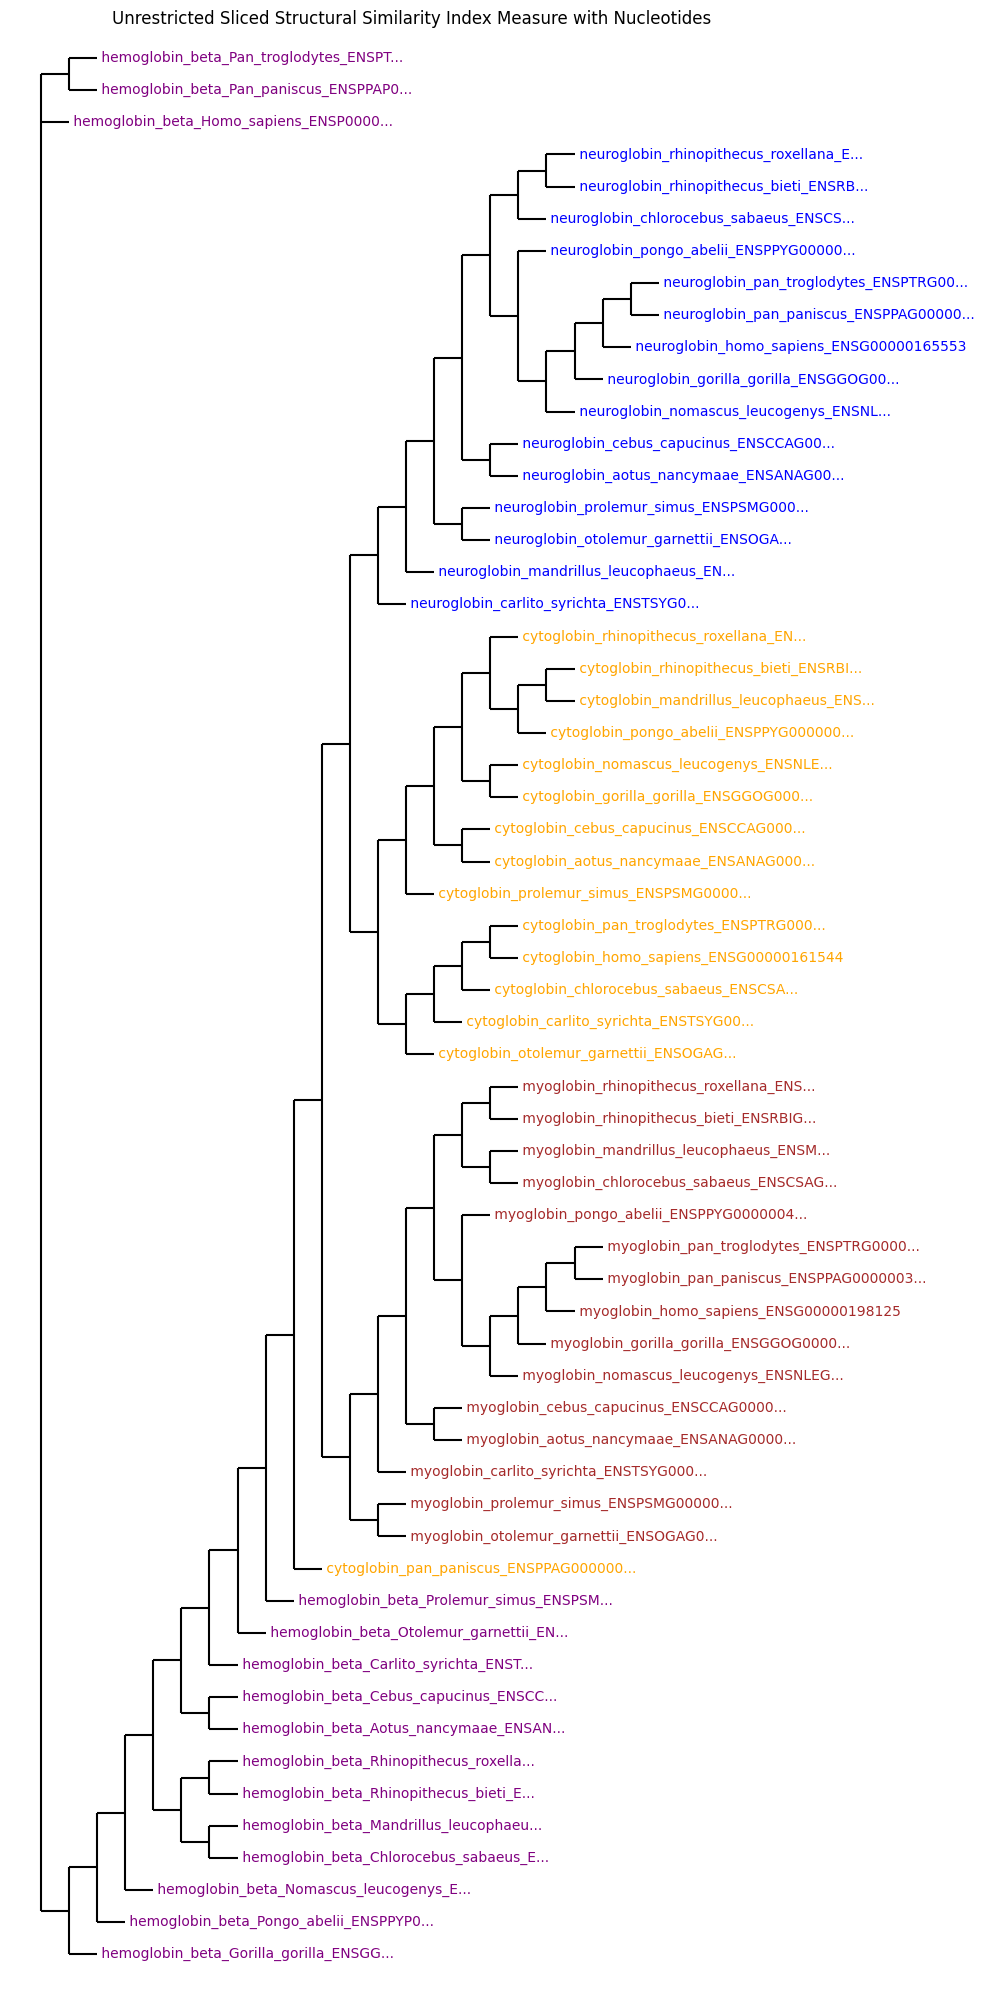

--------Universal Quality Index with Nucleotides--------
cytoglobin
Precision: 0.22857142857142856
Mean Average Precision 0.29453245999500527
-------------------------------------------------
hemoglobin
Precision: 0.9619047619047619
Mean Average Precision 0.9475076419722278
-------------------------------------------------
myoglobin
Precision: 1.0
Mean Average Precision 1.0
-------------------------------------------------
neuroglobin
Precision: 0.7904761904761904
Mean Average Precision 0.7545411142048903
-------------------------------------------------


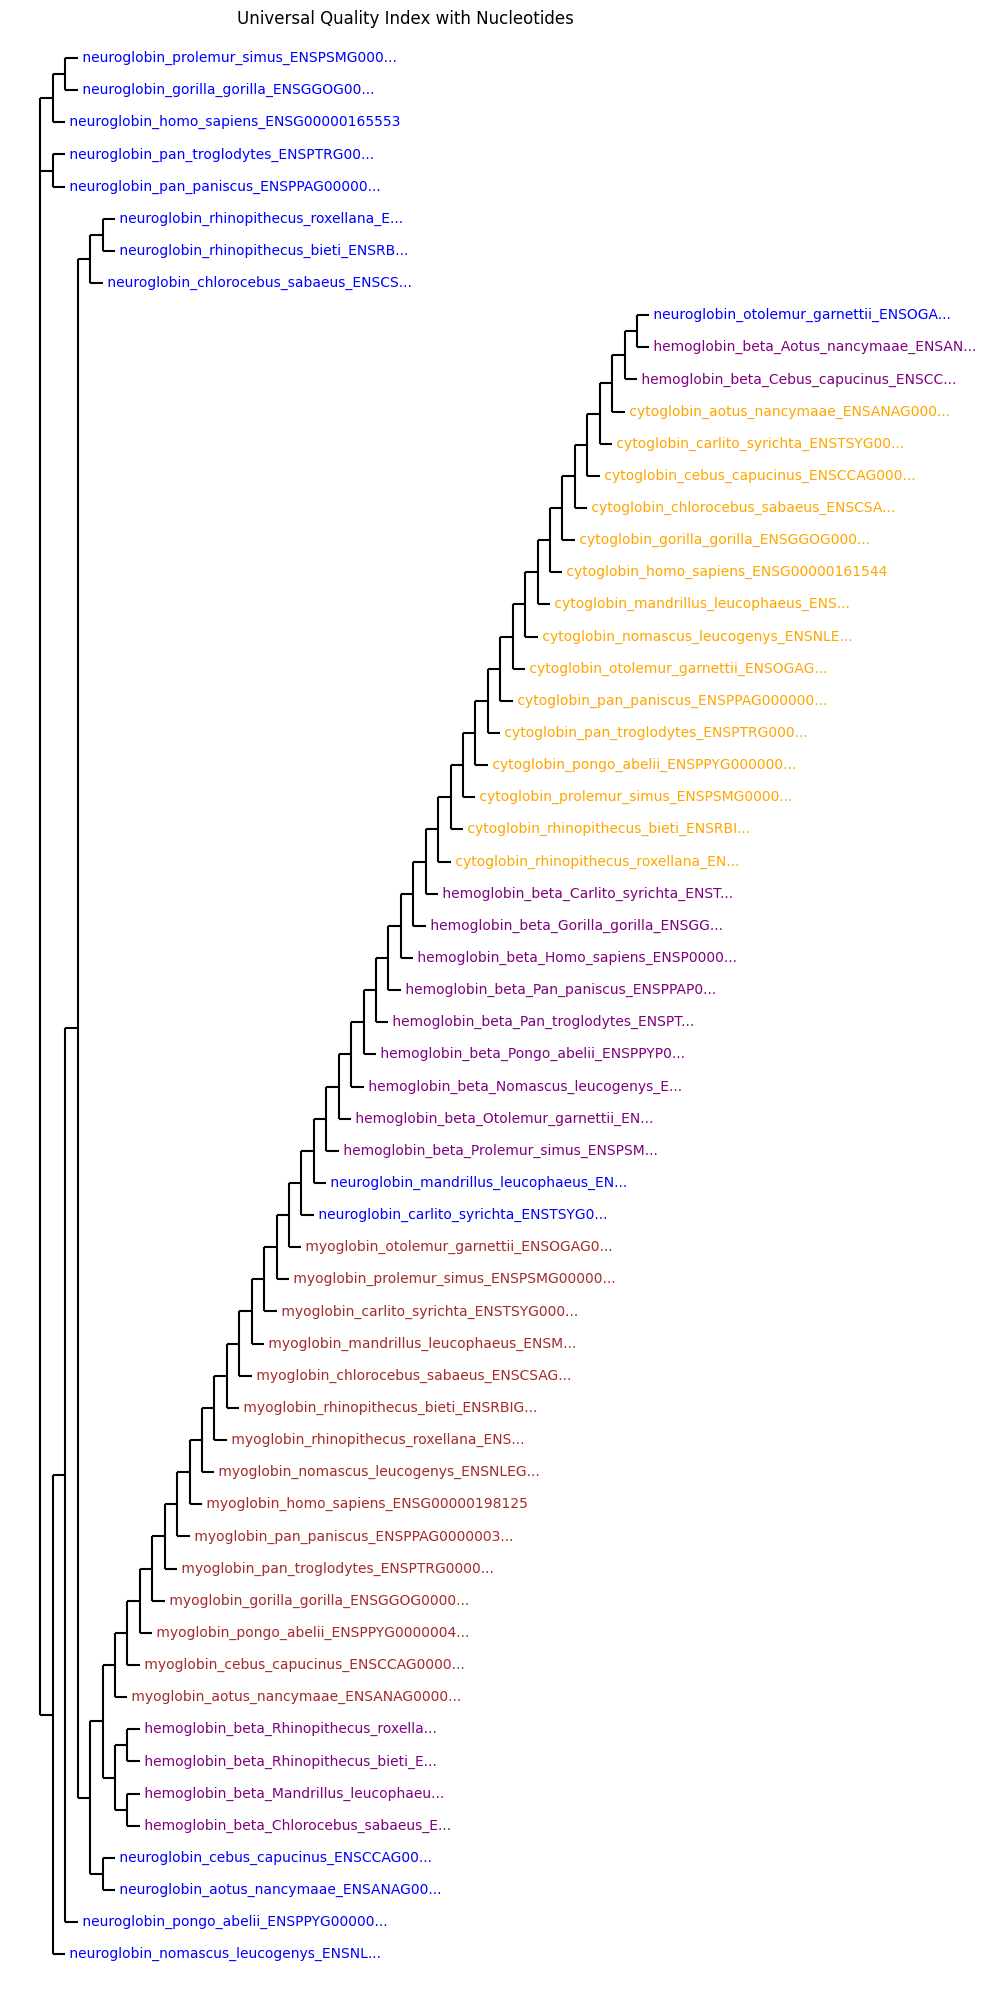

In [11]:
with open(f"{data_path}/cluster_sim.pkl", "rb") as f:
    sim_hash = pickle.load(f)
for types in sim_hash:
    for alg in sim_hash[types]:
        df_all = pandas.DataFrame.from_dict(sim_hash[types][alg])
        df_all.columns = [c.split("/")[-3].split(".")[0] +"_"+ c.split("/")[-1].split(".")[0] for c in df_all.columns]
        df_all.index = [c.split("/")[-3].split(".")[0] +"_"+ c.split("/")[-1].split(".")[0] for c in df_all.index]
        fixed_df_all = df_all.sort_index()[sorted(df_all.columns)]
        calc_map(types, alg, fixed_df_all)
        numpy_all = fixed_df_all.to_numpy(na_value=0)
        show_tree(types, alg, numpy_all)

In [12]:
for types in types_map.keys():
    dfs_control = {}
    control_dir = os.path.join(data_path, "blast", types)
    print(f"--------Results {types_map[types]}--------")
    for f in os.listdir(control_dir):
        if f.endswith(".csv"):
            name = f.split(".")[0]
            dfs_control[name] = pandas.read_csv(os.path.join(control_dir, f))
    for dataset, df_control in dfs_control.items():
        k=15 if "orthologs" in dataset else 40
        name = (dataset.replace("orthologs_", ""),) if "orthologs" in dataset else list(map("".join, itertools.product("ABCD", string.digits)))
        print(dataset)
        results = dfs_control[dataset].groupby("qseqid").head(k).groupby("qseqid").apply(
            lambda x: x["sseqid"].str.split("-", expand = True)[0].isin(name))
        print("Precision:", results.sum() / results.count())
        precision = [0]
        p_k = 0
        for i in results:
            precision.append(i+precision[-1])
        for k in range(1,len(precision)):
            p_k += precision[k]/k
        print("Mean Average Precision", p_k/results.count())
        display(results.groupby("qseqid").agg(right="sum", total="count"))
#         display(df_control.groupby("qseqid").head(k).pivot(index="qseqid", columns="sseqid", values="bitscore"))

--------Results with Protein--------
orthologs_cytoglobin
Precision: 1.0
Mean Average Precision 1.0


right  total
qseqid                                                  
aotus_nancymaae_ENSANAG00000037374             15     15
carlito_syrichta_ENSTSYG00000029754            15     15
cebus_capucinus_ENSCCAG00000037088             15     15
chlorocebus_sabaeus_ENSCSAG00000005082         15     15
gorilla_gorilla_ENSGGOG00000001385             15     15
homo_sapiens_ENSG00000161544                   15     15
mandrillus_leucophaeus_ENSMLEG00000043678      15     15
nomascus_leucogenys_ENSNLEG00000002476         15     15
otolemur_garnettii_ENSOGAG00000034659          15     15
pan_paniscus_ENSPPAG00000043476                15     15
pan_troglodytes_ENSPTRG00000033861             15     15
pongo_abelii_ENSPPYG00000008661                15     15
prolemur_simus_ENSPSMG00000023947              15     15
rhinopithecus_bieti_ENSRBIG00000040278         15     15
rhinopithecus_roxellana_ENSRROG00000038611     15     15

orthologs_androglobin
Precision: 1.0
Mean Average Precision 1.0


right  total
qseqid                                                  
aotus_nancymaae_ENSANAG00000025329             15     15
carlito_syrichta_ENSTSYG00000002644            15     15
cebus_capucinus_ENSCCAG00000032521             15     15
chlorocebus_sabaeus_ENSCSAG00000017175         15     15
gorilla_gorilla_ENSGGOG00000001069             15     15
homo_sapiens_ENSG00000118492                   15     15
mandrillus_leucophaeus_ENSMLEG00000042349      15     15
nomascus_leucogenys_ENSNLEG00000015247         15     15
otolemur_garnettii_ENSOGAG00000024602          15     15
pan_paniscus_ENSPPAG00000031064                15     15
pan_troglodytes_ENSPTRG00000018686             15     15
pongo_abelii_ENSPPYG00000017077                15     15
prolemur_simus_ENSPSMG00000018921              15     15
rhinopithecus_bieti_ENSRBIG00000033722         15     15
rhinopithecus_roxellana_ENSRROG00000037836     15     15

orthologs_hemoglobin_beta
Precision: 1.0
Mean Average Precision 1.0


right  total
qseqid                                                       
Aotus_nancymaae_ENSANAP00000000486_Anan             15     15
Carlito_syrichta_ENSTSYP00000007411_Csyr            15     15
Cebus_capucinus_ENSCCAP00000028244_Ccap             15     15
Chlorocebus_sabaeus_ENSCSAP00000000618_Csab         15     15
Gorilla_gorilla_ENSGGOP00000022371_Ggor             15     15
Homo_sapiens_ENSP00000333994_Hsap                   15     15
Mandrillus_leucophaeus_ENSMLEP00000005381_Mleu      15     15
Nomascus_leucogenys_ENSNLEP00000021062_Nleu         15     15
Otolemur_garnettii_ENSOGAP00000006779_Ogar          15     15
Pan_paniscus_ENSPPAP00000004625_Ppan                15     15
Pan_troglodytes_ENSPTRP00000005700_Ptro             15     15
Pongo_abelii_ENSPPYP00000004109_Pabe                15     15
Prolemur_simus_ENSPSMP00000000465_Psim              15     15
Rhinopithecus_bieti_ENSRBIP00000023384_Rbie         15     15
Rhinopithecus_roxellana_ENSRROP00000025038_Rrox     15     15

orthologs_myoglobin
Precision: 1.0
Mean Average Precision 1.0


right  total
qseqid                                                  
aotus_nancymaae_ENSANAG00000020373             15     15
carlito_syrichta_ENSTSYG00000026219            15     15
cebus_capucinus_ENSCCAG00000031738             15     15
chlorocebus_sabaeus_ENSCSAG00000008174         15     15
gorilla_gorilla_ENSGGOG00000011478             15     15
homo_sapiens_ENSG00000198125                   15     15
mandrillus_leucophaeus_ENSMLEG00000032335      15     15
nomascus_leucogenys_ENSNLEG00000014375         15     15
otolemur_garnettii_ENSOGAG00000005651          15     15
pan_paniscus_ENSPPAG00000036732                15     15
pan_troglodytes_ENSPTRG00000023553             15     15
pongo_abelii_ENSPPYG00000040455                15     15
prolemur_simus_ENSPSMG00000021110              15     15
rhinopithecus_bieti_ENSRBIG00000040058         15     15
rhinopithecus_roxellana_ENSRROG00000020662     15     15

indelible
Precision: 0.588125
Mean Average Precision 0.5934550275847603


right  total
qseqid              
A0         23     40
A1         21     40
A2         23     40
A3         25     40
A4         18     40
A5         16     40
A6         25     40
A7         25     40
A8         27     40
A9         24     40
B0         21     40
B1         24     40
B2         27     40
B3         22     40
B4         21     40
B5         24     40
B6         31     40
B7         29     40
B8         27     40
B9         30     40
C0         32     40
C1         29     40
C2         26     40
C3         26     40
C4         27     40
C5         22     40
C6         19     40
C7         24     40
C8          9     40
C9         26     40
D0         19     40
D1         22     40
D2         26     40
D3         27     40
D4         25     40
D5         16     40
D6         16     40
D7         25     40
D8         17     40
D9         25     40

orthologs_neuroglobin
Precision: 1.0
Mean Average Precision 1.0


right  total
qseqid                                                  
aotus_nancymaae_ENSANAG00000022420             15     15
carlito_syrichta_ENSTSYG00000026821            15     15
cebus_capucinus_ENSCCAG00000020944             15     15
chlorocebus_sabaeus_ENSCSAG00000011845         15     15
gorilla_gorilla_ENSGGOG00000006195             15     15
homo_sapiens_ENSG00000165553                   15     15
mandrillus_leucophaeus_ENSMLEG00000035424      15     15
nomascus_leucogenys_ENSNLEG00000016682         15     15
otolemur_garnettii_ENSOGAG00000006194          15     15
pan_paniscus_ENSPPAG00000040520                15     15
pan_troglodytes_ENSPTRG00000006575             15     15
pongo_abelii_ENSPPYG00000006019                15     15
prolemur_simus_ENSPSMG00000011006              15     15
rhinopithecus_bieti_ENSRBIG00000038926         15     15
rhinopithecus_roxellana_ENSRROG00000044996     15     15

--------Results with Nucleotides--------
orthologs_cytoglobin
Precision: 1.0
Mean Average Precision 1.0


right  total
qseqid                                                  
aotus_nancymaae_ENSANAG00000037374             15     15
carlito_syrichta_ENSTSYG00000029754            15     15
cebus_capucinus_ENSCCAG00000037088             15     15
chlorocebus_sabaeus_ENSCSAG00000005082         15     15
gorilla_gorilla_ENSGGOG00000001385             15     15
homo_sapiens_ENSG00000161544                   15     15
mandrillus_leucophaeus_ENSMLEG00000043678      15     15
nomascus_leucogenys_ENSNLEG00000002476         15     15
otolemur_garnettii_ENSOGAG00000034659          15     15
pan_paniscus_ENSPPAG00000043476                15     15
pan_troglodytes_ENSPTRG00000033861             15     15
pongo_abelii_ENSPPYG00000008661                15     15
prolemur_simus_ENSPSMG00000023947              15     15
rhinopithecus_bieti_ENSRBIG00000040278         15     15
rhinopithecus_roxellana_ENSRROG00000038611     15     15

orthologs_androglobin
Precision: 1.0
Mean Average Precision 1.0


right  total
qseqid                                                  
aotus_nancymaae_ENSANAG00000025329             15     15
carlito_syrichta_ENSTSYG00000002644            15     15
cebus_capucinus_ENSCCAG00000032521             15     15
chlorocebus_sabaeus_ENSCSAG00000017175         15     15
gorilla_gorilla_ENSGGOG00000001069             15     15
homo_sapiens_ENSG00000118492                   15     15
mandrillus_leucophaeus_ENSMLEG00000042349      15     15
nomascus_leucogenys_ENSNLEG00000015247         15     15
otolemur_garnettii_ENSOGAG00000024602          15     15
pan_paniscus_ENSPPAG00000031064                15     15
pan_troglodytes_ENSPTRG00000018686             15     15
pongo_abelii_ENSPPYG00000017077                15     15
prolemur_simus_ENSPSMG00000018921              15     15
rhinopithecus_bieti_ENSRBIG00000033722         15     15
rhinopithecus_roxellana_ENSRROG00000037836     15     15

orthologs_hemoglobin_beta
Precision: 1.0
Mean Average Precision 1.0


right  total
qseqid                                                       
Aotus_nancymaae_ENSANAP00000000486_Anan             15     15
Carlito_syrichta_ENSTSYP00000007411_Csyr            15     15
Cebus_capucinus_ENSCCAP00000028244_Ccap             15     15
Chlorocebus_sabaeus_ENSCSAP00000000618_Csab         15     15
Gorilla_gorilla_ENSGGOP00000022371_Ggor             15     15
Homo_sapiens_ENSP00000333994_Hsap                   15     15
Mandrillus_leucophaeus_ENSMLEP00000005381_Mleu      15     15
Nomascus_leucogenys_ENSNLEP00000021062_Nleu         15     15
Otolemur_garnettii_ENSOGAP00000006779_Ogar          15     15
Pan_paniscus_ENSPPAP00000004625_Ppan                15     15
Pan_troglodytes_ENSPTRP00000005700_Ptro             15     15
Pongo_abelii_ENSPPYP00000004109_Pabe                15     15
Prolemur_simus_ENSPSMP00000000465_Psim              15     15
Rhinopithecus_bieti_ENSRBIP00000023384_Rbie         15     15
Rhinopithecus_roxellana_ENSRROP00000025038_Rrox     15     15

orthologs_myoglobin
Precision: 1.0
Mean Average Precision 1.0


right  total
qseqid                                                  
aotus_nancymaae_ENSANAG00000020373             15     15
carlito_syrichta_ENSTSYG00000026219            15     15
cebus_capucinus_ENSCCAG00000031738             15     15
chlorocebus_sabaeus_ENSCSAG00000008174         15     15
gorilla_gorilla_ENSGGOG00000011478             15     15
homo_sapiens_ENSG00000198125                   15     15
mandrillus_leucophaeus_ENSMLEG00000032335      15     15
nomascus_leucogenys_ENSNLEG00000014375         15     15
otolemur_garnettii_ENSOGAG00000005651          15     15
pan_paniscus_ENSPPAG00000036732                15     15
pan_troglodytes_ENSPTRG00000023553             15     15
pongo_abelii_ENSPPYG00000040455                15     15
prolemur_simus_ENSPSMG00000021110              15     15
rhinopithecus_bieti_ENSRBIG00000040058         15     15
rhinopithecus_roxellana_ENSRROG00000020662     15     15

indelible
Precision: 0.6575
Mean Average Precision 0.6632178984228819


right  total
qseqid              
A0         25     40
A1         26     40
A2         28     40
A3         28     40
A4         24     40
A5         26     40
A6         22     40
A7         26     40
A8         32     40
A9         23     40
B0         25     40
B1         30     40
B2         25     40
B3         27     40
B4         26     40
B5         30     40
B6         24     40
B7         28     40
B8         24     40
B9         23     40
C0         29     40
C1         25     40
C2         24     40
C3         29     40
C4         33     40
C5         25     40
C6         25     40
C7         25     40
C8         31     40
C9         23     40
D0         27     40
D1         27     40
D2         24     40
D3         22     40
D4         28     40
D5         18     40
D6         26     40
D7         33     40
D8         25     40
D9         31     40

orthologs_neuroglobin
Precision: 1.0
Mean Average Precision 1.0


right  total
qseqid                                                  
aotus_nancymaae_ENSANAG00000022420             15     15
carlito_syrichta_ENSTSYG00000026821            15     15
cebus_capucinus_ENSCCAG00000020944             15     15
chlorocebus_sabaeus_ENSCSAG00000011845         15     15
gorilla_gorilla_ENSGGOG00000006195             15     15
homo_sapiens_ENSG00000165553                   15     15
mandrillus_leucophaeus_ENSMLEG00000035424      15     15
nomascus_leucogenys_ENSNLEG00000016682         15     15
otolemur_garnettii_ENSOGAG00000006194          15     15
pan_paniscus_ENSPPAG00000040520                15     15
pan_troglodytes_ENSPTRG00000006575             15     15
pongo_abelii_ENSPPYG00000006019                15     15
prolemur_simus_ENSPSMG00000011006              15     15
rhinopithecus_bieti_ENSRBIG00000038926         15     15
rhinopithecus_roxellana_ENSRROG00000044996     15     15

In [13]:
for types in types_map.keys():
    print(f"--------Results {types_map[types]}--------")
    control_tree = Tree(f"{data_path}/blast/{types}/db_blast_guided.nw", format=1)
    control_phylo_tree = Tree(f"{data_path}/blast/{types}/db_blast_phylo.nw", format=1)
    result_dict = {"control_guided":[], "control_phylo_rf": [], "control_phylo_bs": []}
    print(control_tree.compare(control_phylo_tree, unrooted=True)["norm_rf"])
    indexes = []
    for file in os.listdir(f"{data_path}/blast/{types}/"):
        if file.endswith(".nw") and file.startswith("db_blast "):
            alg = file.split("db_blast ")[1].split(".")[0]
            tree = Tree(f"{data_path}/blast/{types}/{file}", format=1)
            result = control_tree.compare(tree, unrooted=True)
            result_dict["control_guided"].append((result["norm_rf"], 1.0 - result["source_edges_in_ref"]))
            result = control_phylo_tree.compare(tree, unrooted=True)
            result_dict["control_phylo_rf"].append(result["norm_rf"])
            result_dict["control_phylo_bs"].append(1.0 - result["source_edges_in_ref"])
            indexes.append(alg)
    display(pandas.DataFrame(result_dict, index=indexes))

--------Results with Protein--------
0.21428571428571427


control_guided  \
Resized MultiScale Structural Similarity Index ...  (0.42857142857142855, 0.21238938053097345)   
Resized Structural Similarity Index Measure         (0.42857142857142855, 0.21238938053097345)   
Universal Quality Index                             (0.42857142857142855, 0.21238938053097345)   
Windowed MultiScale Structural Similarity Index...  (0.39285714285714285, 0.19469026548672563)   
Unrestricted Sliced Structural Similarity Index...   (0.4107142857142857, 0.20353982300884954)   
Greedy Sliced Structural Similarity Index Measure   (0.39285714285714285, 0.19469026548672563)   

                                                    control_phylo_rf  \
Resized MultiScale Structural Similarity Index ...          0.446429   
Resized Structural Similarity Index Measure                 0.473214   
Universal Quality Index                                     0.464286   
Windowed MultiScale Structural Similarity Index...          0.366071   
Unrestricted Sliced Structural Similarity Index...          0.428571   
Greedy Sliced Structural Similarity Index Measure           0.446429   

                                                    control_phylo_bs  
Resized MultiScale Structural Similarity Index ...          0.221239  
Resized Structural Similarity Index Measure                 0.234513  
Universal Quality Index                                     0.230088  
Windowed MultiScale Structural Similarity Index...          0.181416  
Unrestricted Sliced Structural Similarity Index...          0.212389  
Greedy Sliced Structural Similarity Index Measure           0.221239

--------Results with Nucleotides--------
0.15178571428571427


control_guided  \
Resized MultiScale Structural Similarity Index ...  (0.38596491228070173, 0.18965517241379315)   
Resized Structural Similarity Index Measure          (0.3157894736842105, 0.15517241379310343)   
Universal Quality Index                              (0.8771929824561403, 0.43103448275862066)   
Windowed MultiScale Structural Similarity Index...    (0.3333333333333333, 0.1637931034482759)   
Unrestricted Sliced Structural Similarity Index...   (0.2807017543859649, 0.13793103448275867)   
Greedy Sliced Structural Similarity Index Measure    (0.3157894736842105, 0.15517241379310343)   

                                                    control_phylo_rf  \
Resized MultiScale Structural Similarity Index ...          0.385965   
Resized Structural Similarity Index Measure                 0.298246   
Universal Quality Index                                     0.877193   
Windowed MultiScale Structural Similarity Index...          0.280702   
Unrestricted Sliced Structural Similarity Index...          0.228070   
Greedy Sliced Structural Similarity Index Measure           0.263158   

                                                    control_phylo_bs  
Resized MultiScale Structural Similarity Index ...          0.189655  
Resized Structural Similarity Index Measure                 0.146552  
Universal Quality Index                                     0.431034  
Windowed MultiScale Structural Similarity Index...          0.137931  
Unrestricted Sliced Structural Similarity Index...          0.112069  
Greedy Sliced Structural Similarity Index Measure           0.129310

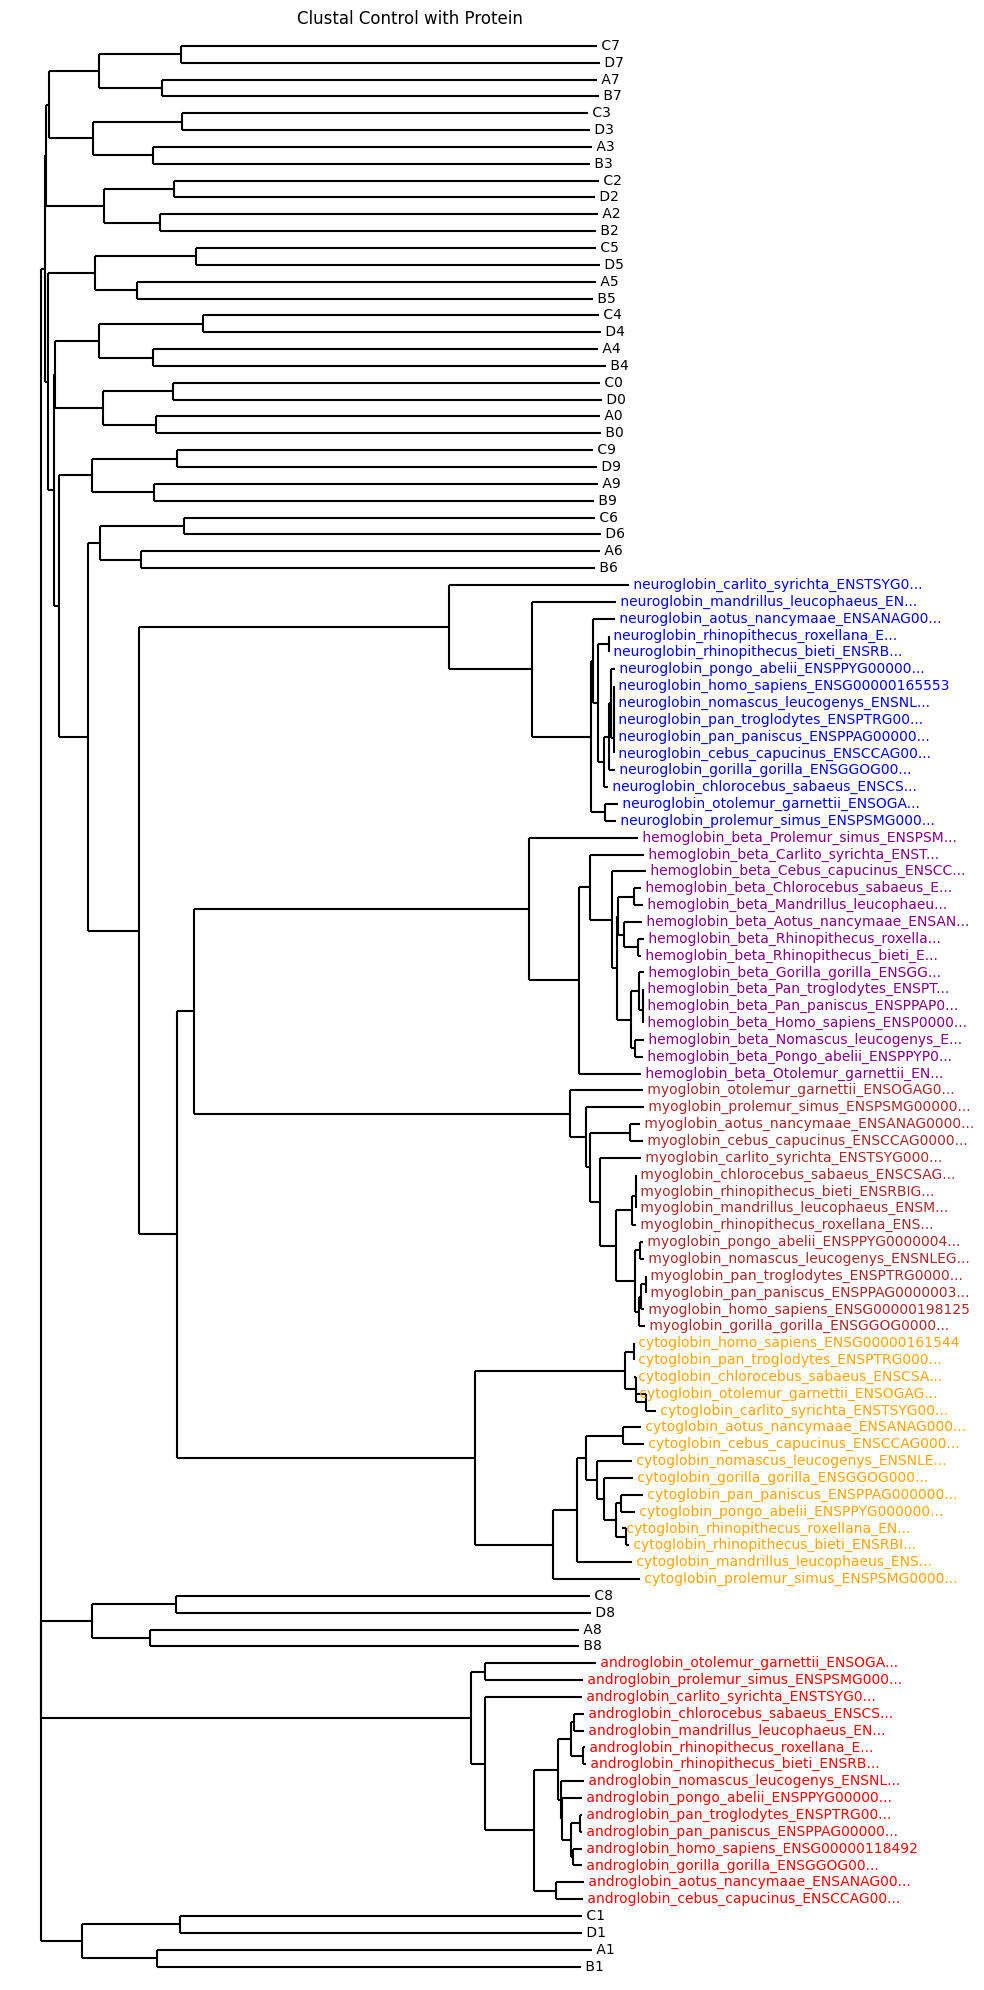

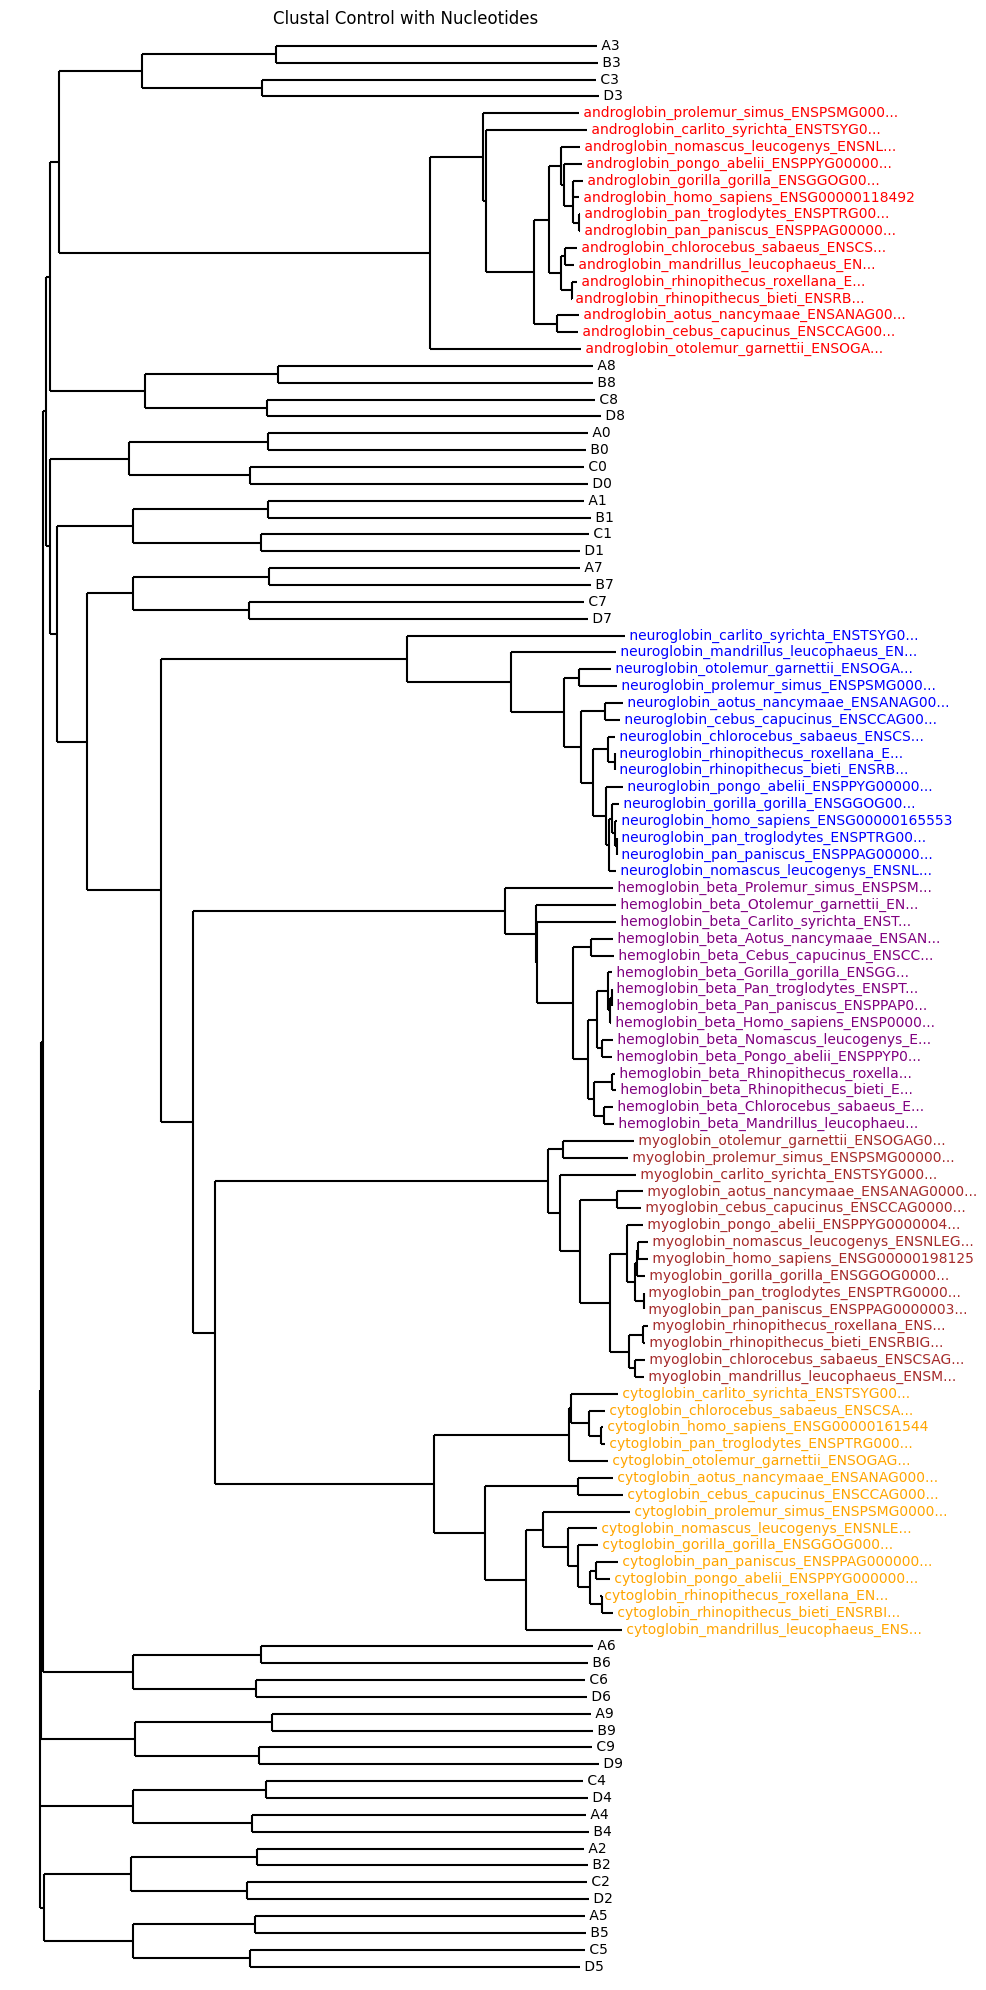

In [14]:
for types in types_map.keys():
    fig, ax = pyplot.subplots(1, 1, figsize=(10, 20), layout="constrained")
    t = Phylo.read(f"{data_path}/blast/{types}/db_blast_phylo.nw", "newick")
    # for a, b in itertools.product("ABCD", "0123456789"):
    #     c = next(t.find_clades(a+b))
    #     c.name = f"indelible_{c.name}"

    # t.ladderize()
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Clustal Control {types_map[types]}")
    ax.axis('off')
    Phylo.draw(
        t,
        show_confidence=False,
        axes=ax,
        do_show=False,
        label_colors=color_clade,
        branch_labels=lambda clade: "" if not clade.name else "{:.2f}".format(
            clade.confidence) if clade.confidence else ""
    )
    pyplot.xlabel("")
    pyplot.ylabel("")
    pyplot.tight_layout()
    pyplot.show()